In [2]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


Getting the stock
(stocks are not survivorship bias free - limitations)

In [3]:
import requests, certifi
import pandas as pd

# Use the certifi CA bundle for verification
resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', verify=certifi.where())
resp.raise_for_status()    # will error out if we get a bad HTTP status

# Now let pandas parse the HTML string
sp500 = pd.read_html(resp.text)[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')
symbols_list = sp500['Symbol'].unique().tolist()



In [4]:
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)
start_date = pd.to_datetime(start_date)

import yfinance as yf

df = yf.download(symbols_list, start = start_date, end=end_date, auto_adjust=False)



[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
['GEV', 'SOLV', 'VLTO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


In [5]:
# Method 1: using df.drop with level
df_clean = df.drop(labels=['VLTO', 'GEV', 'SOLV'], axis=1, level='Ticker')


In [6]:
df = df_clean
df = df.stack()
df

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2015-09-29 A        31.185328   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.536379   27.264999   28.377501   26.965000   28.207500   
           ABBV     34.760975   52.790001   54.189999   51.880001   53.099998   
           ABT      32.674095   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYZ      44.810001   44.810001   45.740002   44.560001   44.939999   
           YUM     119.860718  124.010002  124.739998  123.449997  124.239998   
           ZBH     110.513580  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     173.026108  176.869995  178.449997  176.270004  176.580002   

Price                   Volume  
Date       Ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0  
...                        ...  
2023-09-26 XYZ      10168200.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[981146 rows x 6 columns]

In [7]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.185328   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.536379   27.264999   28.377501   26.965000   28.207500   
           ABBV     34.760975   52.790001   54.189999   51.880001   53.099998   
           ABT      32.674095   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYZ      44.810001   44.810001   45.740002   44.560001   44.939999   
           YUM     119.860718  124.010002  124.739998  123.449997  124.239998   
           ZBH     110.513580  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     173.026108  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0  
...                        ...  
2023-09-26 XYZ      10168200.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[981146 rows x 6 columns]

Calculate features and technical indicators

In [8]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low =stock_data['low'],
                        close = stock_data['close'],
                        length = 14
                        )
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys = False).apply(compute_atr)



def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6




df



Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.185328   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.536379   27.264999   28.377501   26.965000   28.207500   
           ABBV     34.760975   52.790001   54.189999   51.880001   53.099998   
           ABT      32.674095   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYZ      44.810001   44.810001   45.740002   44.560001   44.939999   
           YUM     119.860718  124.010002  124.739998  123.449997  124.239998   
           ZBH     110.513580  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     173.026108  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001458        NaN       NaN   
           AAPL    293461600.0         -0.006207        NaN       NaN   
           ABBV     12842800.0         -0.068393        NaN       NaN   
           ABT      12287500.0         -0.012625        NaN       NaN   
           ACGL      1888800.0         -0.000516        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYZ      10168200.0          0.000338  25.939817  3.799574   
           YUM       1500600.0         -0.000443  36.057193  4.792447   
           ZBH       3610500.0         -0.000336  31.893249  4.736766   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0         -0.000084  42.623456  5.141724   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.241832  
           AAPL         NaN       NaN       NaN       NaN    7200.484999  
           ABBV         NaN       NaN       NaN       NaN     446.428248  
           ABT          NaN       NaN       NaN       NaN     401.482944  
           ACGL         NaN       NaN       NaN       NaN      43.853730  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYZ     3.980555  4.161536 -0.637443 -0.990293     455.637056  
           YUM     4.822408  4.852369  0.142547 -1.363696     179.862993  
           ZBH     4.776429  4.816093 -0.381708 -0.881067     399.009282  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.200533  5.259341  0.651515 -1.188278     253.171801  

[981146 rows x 14 columns]

Aggregate to monthly level nd filter top 150 liquid stocks for each month. This is to reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.


In [9]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]


data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

data2 = data
data2

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          134.704663   38.653538         -0.002562  73.421367   
           AAPL      4005.252599   26.729137         -0.003654  55.537383   
           ABBV       322.941677   38.643806         -0.073821  49.376880   
           ABT        206.572092   37.373234         -0.014661  56.962639   
           ACGL        28.174423   22.970539         -0.001121  35.682522   
...                          ...         ...               ...        ...   
2023-09-30 EXE        116.692167   79.277855         -0.000348  44.326491   
           COIN       506.942443   70.519997          0.001007  39.839731   
           CEG        195.364203  107.145660         -0.000064  55.245444   
           GEHC       211.835328   65.992210          0.000182  40.922325   
           KVUE       646.497258   19.281166         -0.001506  35.706323   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.536749  3.609179  3.681609 -1.033887  0.567157  
           AAPL    3.277189  3.320493  3.363797 -0.967900 -0.142790  
           ABBV    3.683500  3.731698  3.779896 -0.526809  0.145677  
           ABT     3.632364  3.654204  3.676044 -1.064842  0.335557  
           ACGL    3.177974  3.195190  3.212406 -1.155694 -0.550166  
...                     ...       ...       ...       ...       ...  
2023-09-30 EXE     4.369458  4.422967  4.476475 -1.067686 -0.831788  
           COIN    4.273572  4.378785  4.483998 -1.183735  0.049978  
           CEG     4.645547  4.685718  4.725889 -0.436215  0.366875  
           GEHC    4.153380  4.210914  4.268448 -0.893478 -1.116463  
           KVUE    2.979201  3.054020  3.128840 -0.899746 -1.435622  

[46327 rows x 9 columns]

5 year rolling average of dollar volume for each stocks before filtering

In [10]:
data2['dollar_volume'] = (data2.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data2['dollar_vol_rank'] = (data2.groupby('date')['dollar_volume'].rank(ascending=False))


data2 = data2[data2['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis = 1)
data2

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAPL     26.090456         -0.002767  49.891061  3.289745   
           ABBV     38.501820         -0.059393  27.477732  3.710224   
           ABT      33.469269         -0.010344  38.008845  3.531008   
           ACN     101.760155         -0.006263  53.823635  4.619889   
           ADBE    107.510002          0.000059  53.668389  4.679513   
...                       ...               ...        ...       ...   
2023-09-30 DDOG     86.570000          0.000314  37.040091  4.476874   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           DASH     74.580002          0.000326  36.955365  4.329191   
           ABNB    132.279999          0.000213  44.494127  4.857047   
           COIN     70.519997          0.001007  39.839731  4.273572   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAPL    3.318620  3.347495 -1.038688 -0.195978  
           ABBV    3.764332  3.818440 -0.893132 -0.760594  
           ABT     3.581448  3.631888 -1.035224 -0.650888  
           ACN     4.631525  4.643160 -0.996806 -0.135456  
           ADBE    4.694639  4.709766 -1.230331 -0.109039  
...                     ...       ...       ...       ...  
2023-09-30 DDOG    4.560278  4.643681 -0.867969 -0.699392  
           PLTR    2.779743  2.857548 -0.426167 -0.433581  
           DASH    4.403906  4.478620 -1.145418 -0.117919  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  
           COIN    4.378785  4.483998 -1.183735  0.049978  

[12516 rows x 8 columns]

Monthly returns for different time horizons as features

In [11]:
def calculate_returns(data2):
    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]
    for lag in lags:
        data2 [f'return_{lag}m'] = (data2['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                    upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1)
                            )
    return data2

data3 = data2.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data3

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAPL     39.529034         -0.001263  69.196690  3.590193   
           ABBV     64.567635         -0.044945  55.247846  4.153099   
           ABT      47.327900         -0.007607  53.844935  3.868742   
           ACN     127.138962         -0.005423  69.365199  4.785195   
           ADBE    175.160004          0.000067  70.089317  4.951759   
...                       ...               ...        ...       ...   
2023-09-30 DDOG     86.570000          0.000314  37.040091  4.476874   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           DASH     74.580002          0.000326  36.955365  4.329191   
           ABNB    132.279999          0.000213  44.494127  4.857047   
           COIN     70.519997          0.001007  39.839731  4.273572   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAPL    3.637059  3.683926 -0.906642 -0.039275   0.096808   
           ABBV    4.199430  4.245761  0.375557  0.473814   0.022728   
           ABT     3.892300  3.915859 -1.040044  0.276132   0.021276   
           ACN     4.824869  4.864543 -0.986514  0.352341   0.064180   
           ADBE    5.089292  5.226825 -0.888269  0.612102   0.174152   
...                     ...       ...       ...       ...        ...   
2023-09-30 DDOG    4.560278  4.643681 -0.867969 -0.699392  -0.102716   
           PLTR    2.779743  2.857548 -0.426167 -0.433581  -0.068091   
           DASH    4.403906  4.478620 -1.145418 -0.117919  -0.113515   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   
           COIN    4.378785  4.483998 -1.183735  0.049978  -0.114070   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
           ADBE     0.062497   0.061392   0.045993   0.049515    0.041515  
...                      ...        ...        ...        ...         ...  
2023-09-30 DDOG    -0.138786  -0.041732   0.029624   0.018352   -0.002098  
           PLTR    -0.161174  -0.030723   0.087272   0.090143    0.046083  
           DASH    -0.093658  -0.008091   0.027006   0.048207    0.034568  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  
           COIN    -0.154340  -0.004822   0.007147   0.079010    0.007477  

[10317 rows x 14 columns]

Fama french to estimate the exposure of assets to common risk factors

In [12]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start = '2010'
               )[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name ='date'


factor_data = factor_data.join(data3['return_1m']).sort_index()


factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.096808
           ABBV    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.022728
           ABT     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.021276
           ACN     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.064180
           ADBE    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 WDAY   -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.062413
           WFC    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.015500
           WMT    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.000676
           XOM    -0.0523 -0.0178  0.0149  0.0187 -0.0077   0.046947
           XYZ    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.222723

[10317 rows x 6 columns]

Filter stocks with incomplete data (less than 10 months)

In [13]:
obs = factor_data.groupby(level=1).size()

valid_stocks = obs[obs >= 11]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.096808
           ABBV    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.022728
           ABT     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.021276
           ACN     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.064180
           ADBE    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 WDAY   -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.062413
           WFC    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.015500
           WMT    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.000676
           XOM    -0.0523 -0.0178  0.0149  0.0187 -0.0077   0.046947
           XYZ    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.222723

[10259 rows x 6 columns]

Rolling Factor Betas

In [14]:
betas = (
    factor_data.groupby(level=1, group_keys=False)
    .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                exog = sm.add_constant(x.drop('return_1m', axis = 1)),
                                window = min(24, x.shape[0]),
                                min_nobs = len(x.columns)+1)
           .fit(params_only=True)
           .params
           .drop('const', axis=1))
    )

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 WDAY    1.080889 -0.943888 -0.563591 -0.904332 -0.245654
           WFC     1.122065  0.240834  2.052975 -0.498806 -1.544764
           WMT     0.703876 -0.314958 -0.404473 -0.145430  0.500272
           XOM     0.983370 -1.133544  1.727318 -0.688371 -0.355505
           XYZ     2.417771  1.930175 -0.346912 -1.674851  0.482785

[10259 rows x 5 columns]

In [15]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
 
data3 = (data3.join(betas.groupby('ticker').shift()))

data3.loc[:, factors] = data3.groupby('ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))

data3 = data3.drop('adj close', axis = 1)
#data3 = data.dropna()
data3.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10317 entries, (Timestamp('2017-10-31 00:00:00'), 'AAPL') to (Timestamp('2023-09-30 00:00:00'), 'COIN')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10317 non-null  float64
 1   rsi               10317 non-null  float64
 2   bb_low            10317 non-null  float64
 3   bb_mid            10317 non-null  float64
 4   bb_high           10317 non-null  float64
 5   atr               10317 non-null  float64
 6   macd              10317 non-null  float64
 7   return_1m         10317 non-null  float64
 8   return_2m         10317 non-null  float64
 9   return_3m         10317 non-null  float64
 10  return_6m         10317 non-null  float64
 11  return_9m         10317 non-null  float64
 12  return_12m        10317 non-null  float64
 13  Mkt-RF            10066 non-null  float64
 14  SMB               10066 non-null  float64
 15  HML      

K-Means Clustering to group similar assets based on their features.

In [18]:
from sklearn.cluster import KMeans

#data3 = data3.drop('cluster', axis = 1)

def get_clusters(data3):
    data3['cluster'] = KMeans(n_clusters = 4,
                           random_state = 0,
                           init = 'random'
                           ).fit(data3).labels_
    return data3

data3 = data3.dropna().groupby('date', group_keys = False).apply(get_clusters)

data3

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAPL           -0.001263  69.196690  3.590193  3.637059  3.683926   
           ABBV           -0.044945  55.247846  4.153099  4.199430  4.245761   
           ABT            -0.007607  53.844935  3.868742  3.892300  3.915859   
           ACN            -0.005423  69.365199  4.785195  4.824869  4.864543   
           ADBE            0.000067  70.089317  4.951759  5.089292  5.226825   
...                             ...        ...       ...       ...       ...   
2023-09-30 XYZ             0.000338  25.939817  3.799574  3.980555  4.161536   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   
           DDOG            0.000314  37.040091  4.476874  4.560278  4.643681   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAPL   -0.906642 -0.039275   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473814   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276132   0.021276   0.034308   0.034801   
           ACN    -0.986514  0.352341   0.064180   0.048454   0.037202   
           ADBE   -0.888269  0.612102   0.174152   0.062497   0.061392   
...                     ...       ...        ...        ...        ...   
2023-09-30 XYZ    -0.637443 -0.990293  -0.222723  -0.247423  -0.123607   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   
           DDOG   -0.867969 -0.699392  -0.102716  -0.138786  -0.041732   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAPL     0.028875   0.038941    0.035228  1.276569 -0.251245   
           ABBV     0.056495   0.047273    0.044026  0.505456  0.360918   
           ABT      0.038672   0.031320    0.029294  0.833395 -0.194766   
           ACN      0.028692   0.027398    0.018728  1.203810 -0.154553   
           ADBE     0.045993   0.049515    0.041515  1.109843 -0.318357   
...                      ...        ...         ...       ...       ...   
2023-09-30 XYZ     -0.068630  -0.036876   -0.016915  2.425570  1.931592   
           MRNA    -0.071952  -0.064976   -0.015431  1.153178  0.830602   
           UBER     0.057244   0.066838    0.043691  1.089217  1.124109   
           CRWD     0.026391   0.047942   -0.002216  0.596191 -0.982986   
           DDOG     0.029624   0.018352   -0.002098  0.597929  1.152889   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAPL   -0.610475  0.680494  0.488773        2  
           ABBV   -0.030514  0.179045  0.188219        1  
           ABT    -0.528555  0.255641  0.985794        1  
           ACN    -0.339661  0.270193  0.196833        2  
           ADBE   -0.184547 -0.218160 -0.687488        2  
...                     ...       ...       ...      ...  
2023-09-30 XYZ    -0.379994 -1.634597  0.504004        3  
           MRNA   -1.184440  0.622973  1.031970        1  
           UBER   -0.230914 -1.531753 -0.492249        0  
           CRWD   -0.702390 -2.504872 -0.806021        2  
           DDOG   -0.670874 -0.679475 -0.694354        1  

[10066 rows x 19 columns]

In [19]:
def plot_clusters(data3):
    cluster_0 = data3[data3['cluster']==0]
    cluster_1 = data3[data3['cluster']==1]
    cluster_2 = data3[data3['cluster']==2]
    cluster_3 = data3[data3['cluster']==3]
    
    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6], color = 'red', label = 'cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6], color = 'green', label = 'cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6], color = 'blue', label = 'cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6], color = 'black', label = 'cluster 3')
    
    plt.legend()
    plt.show()
    return

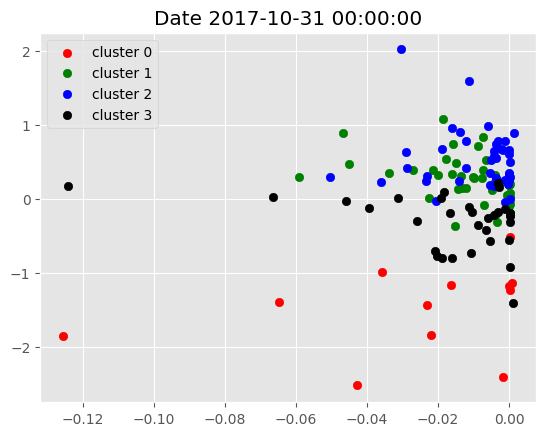

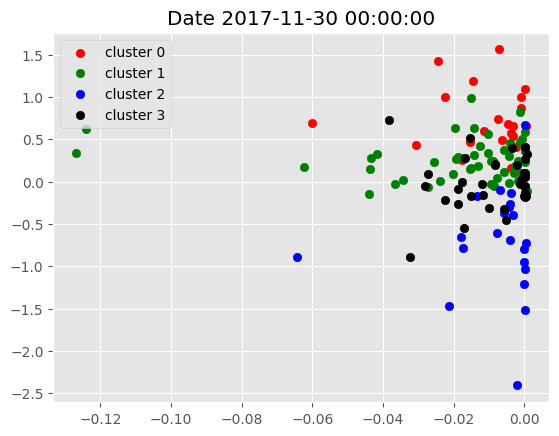

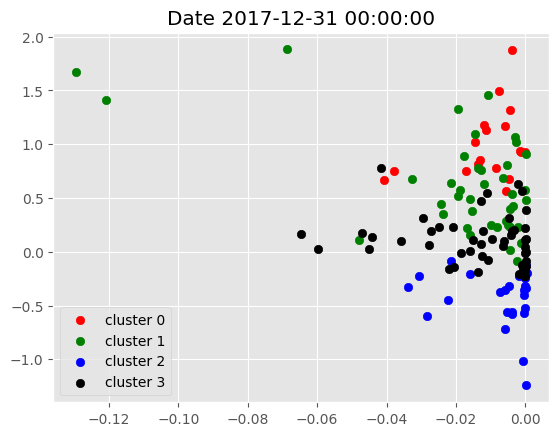

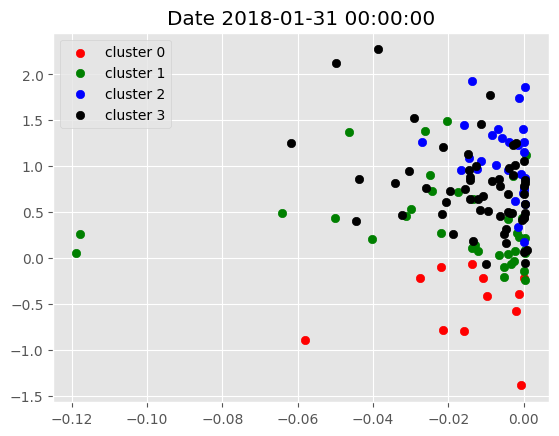

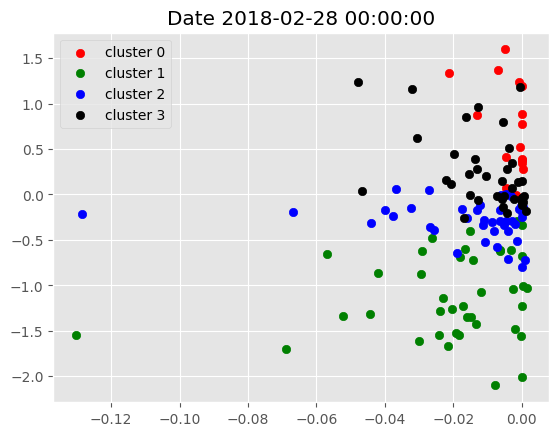

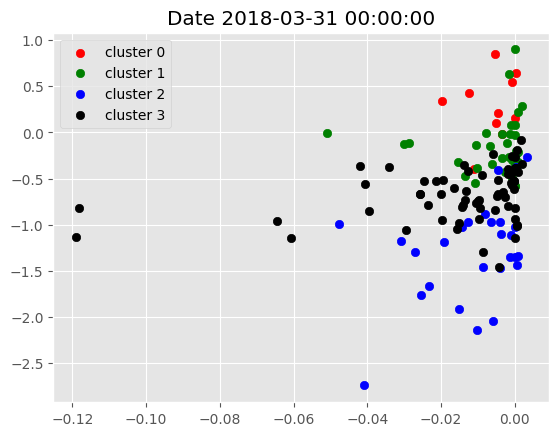

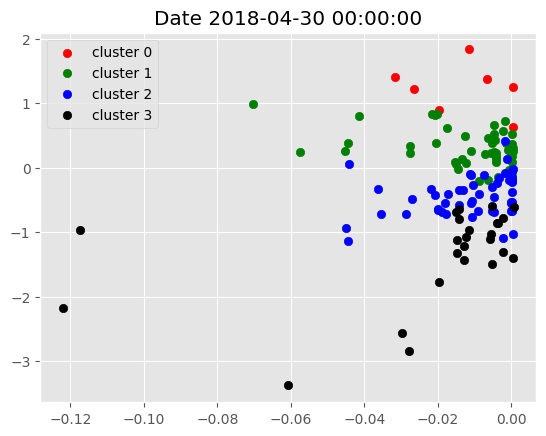

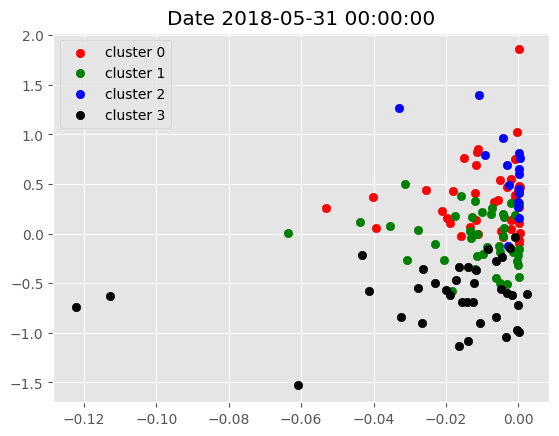

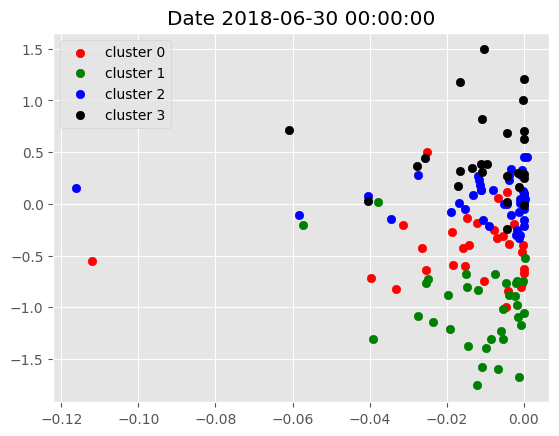

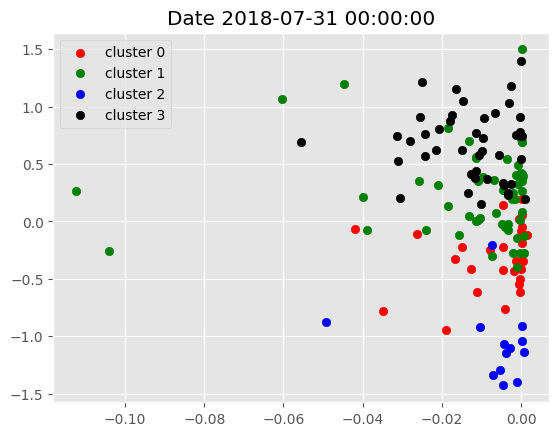

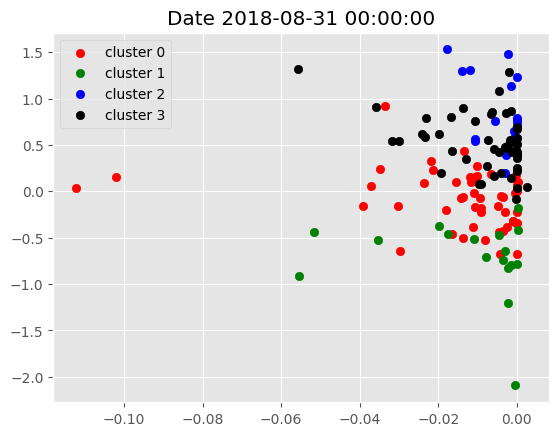

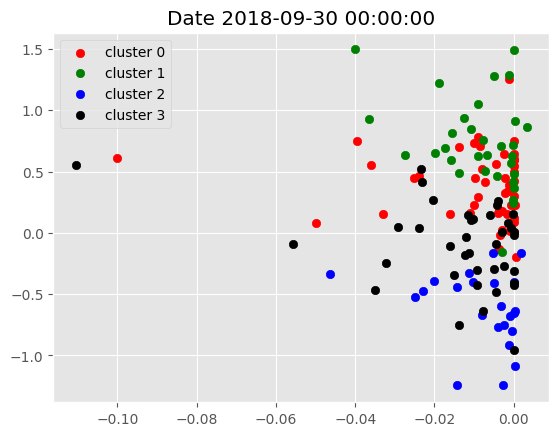

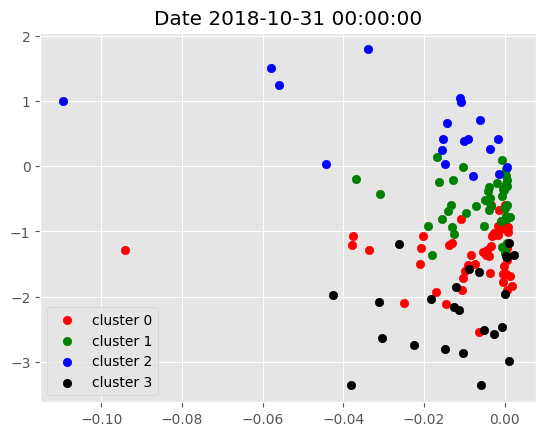

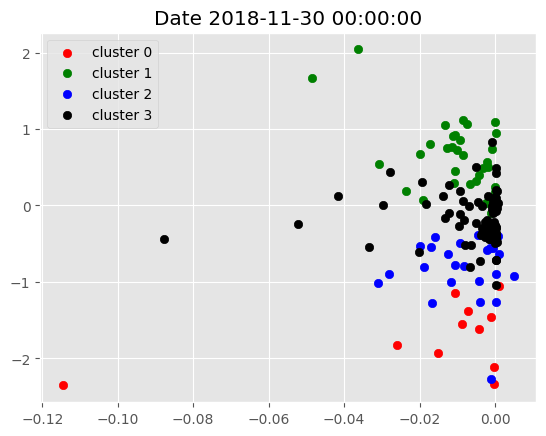

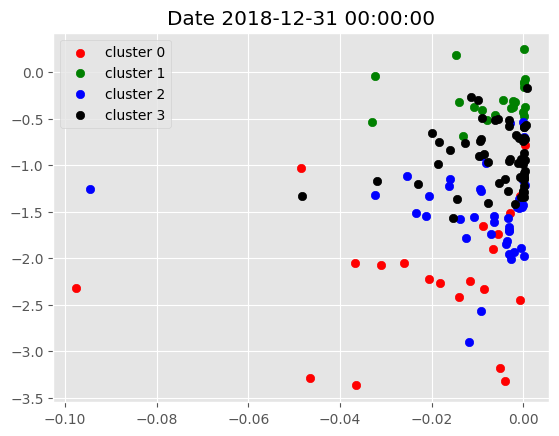

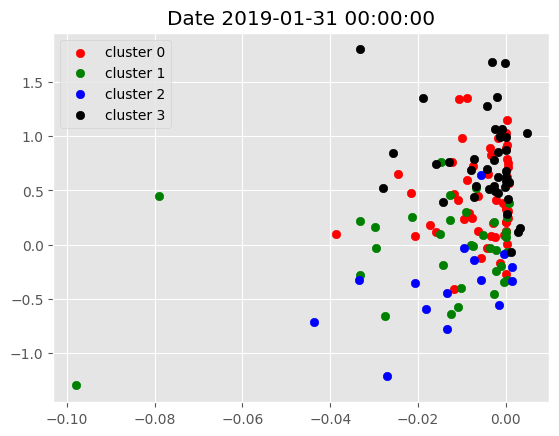

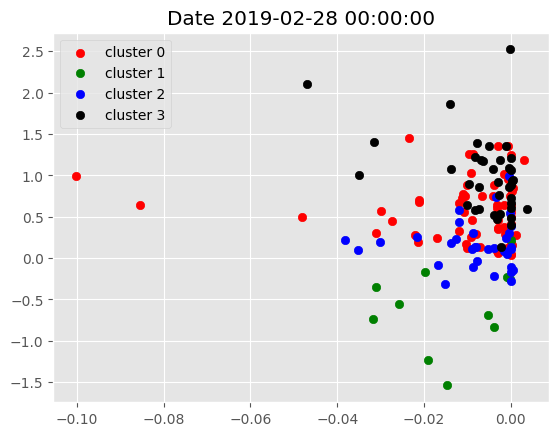

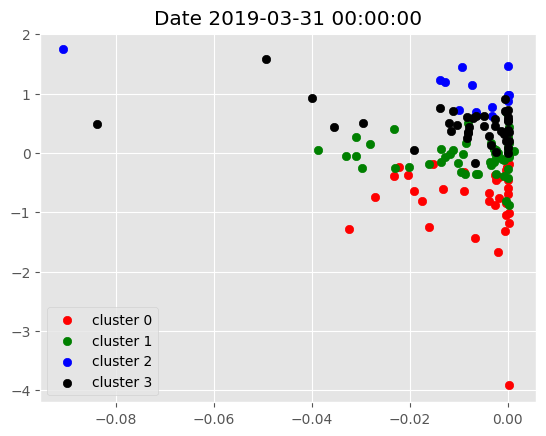

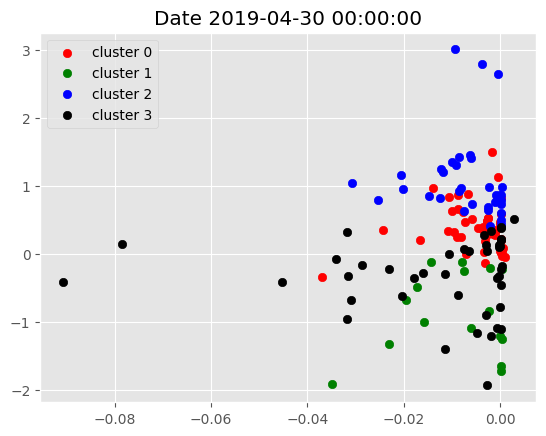

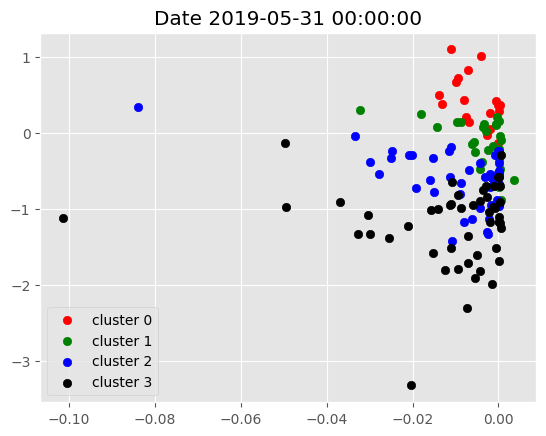

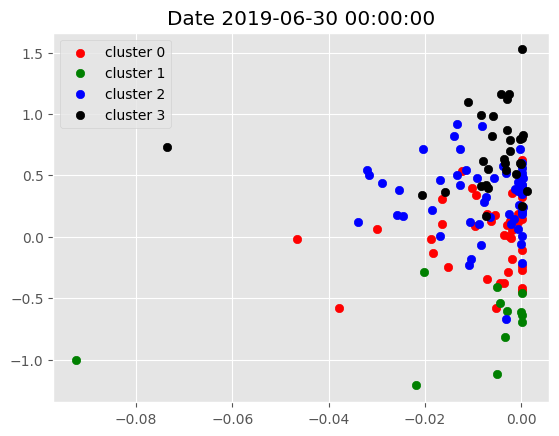

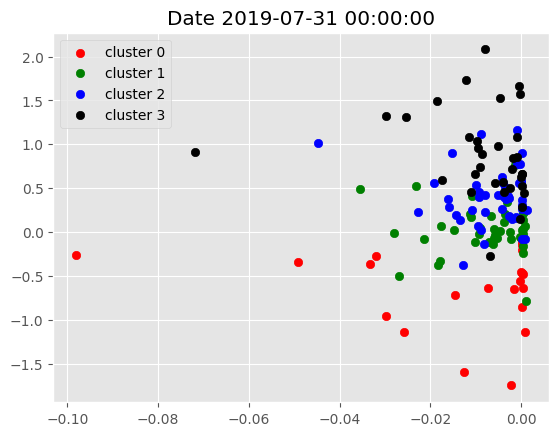

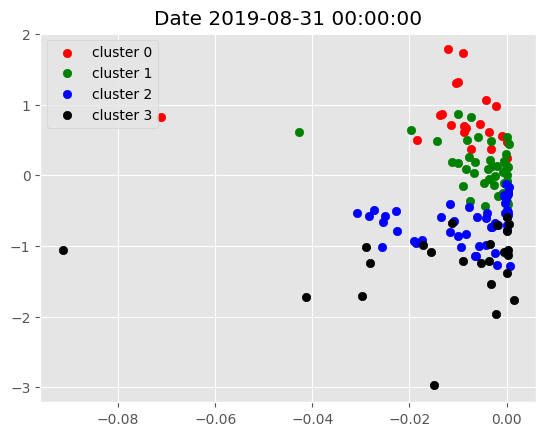

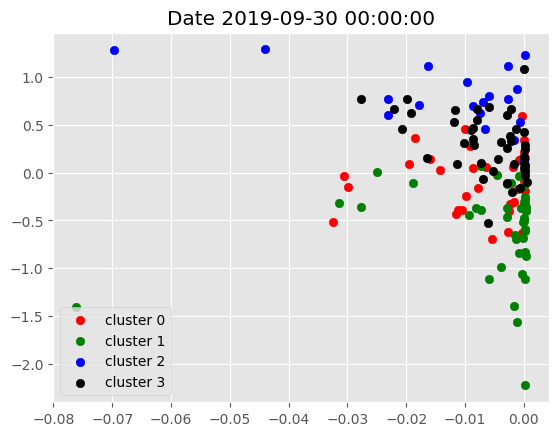

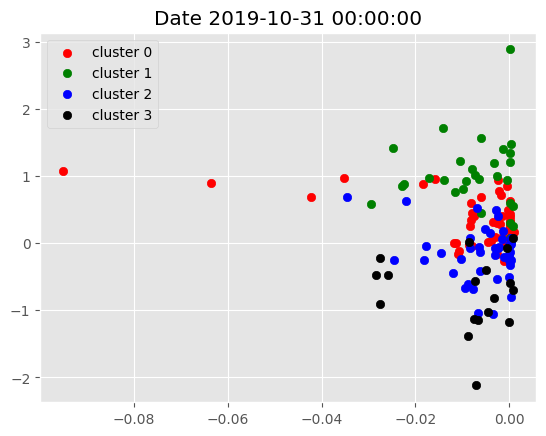

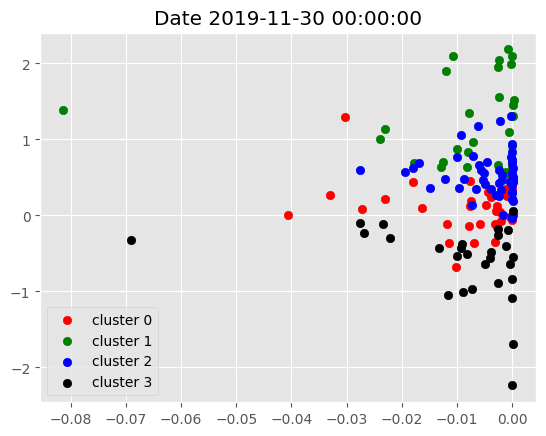

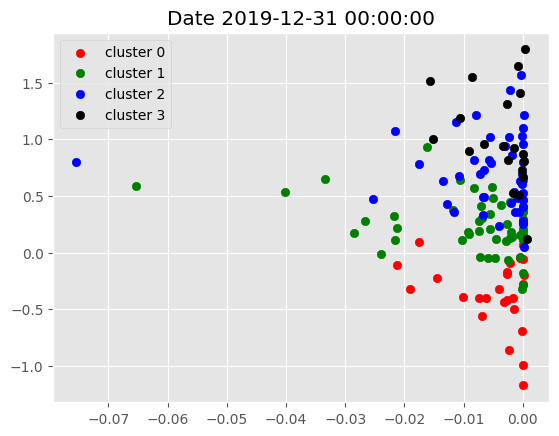

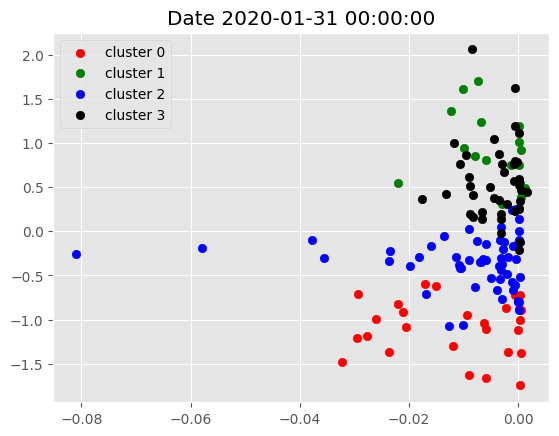

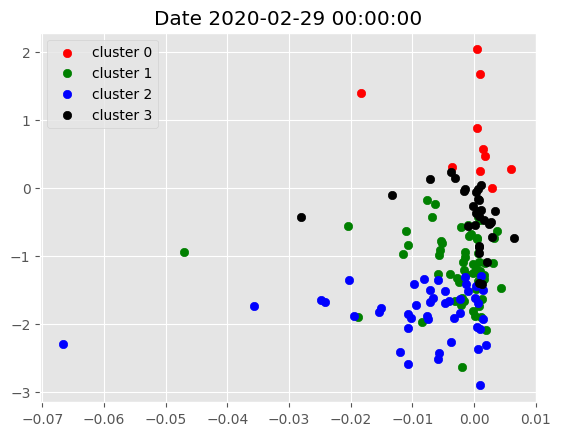

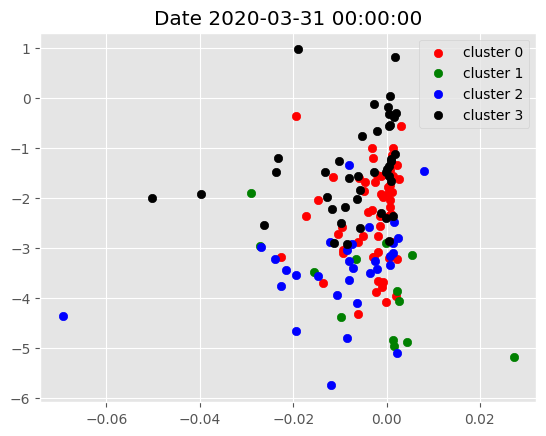

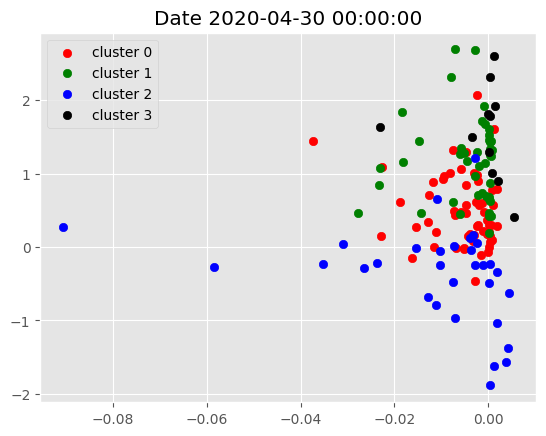

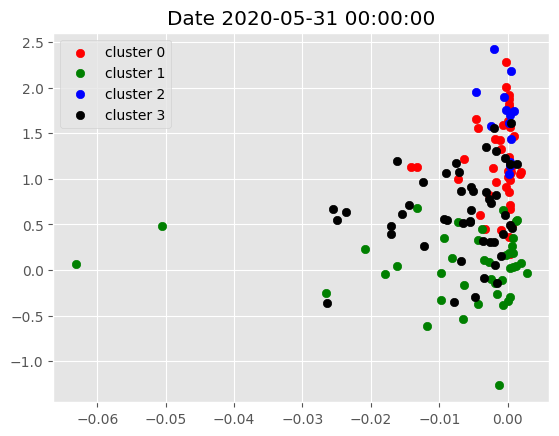

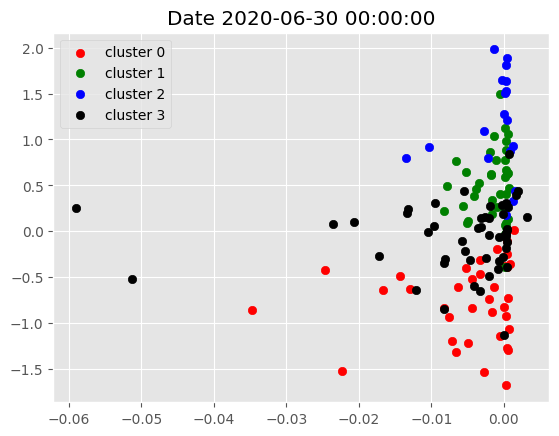

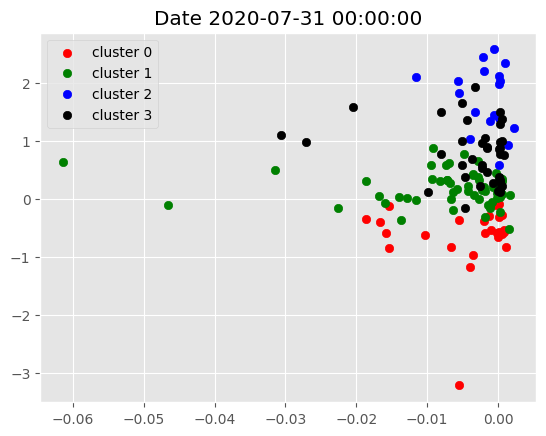

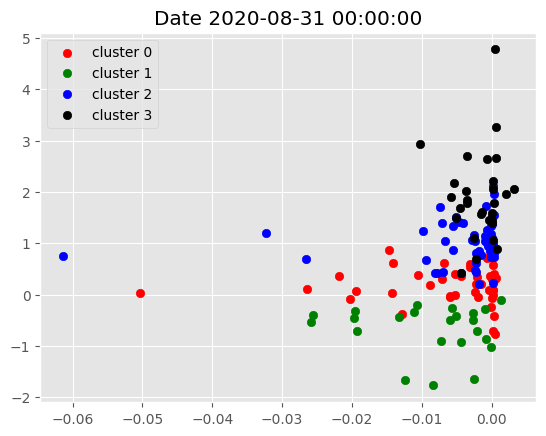

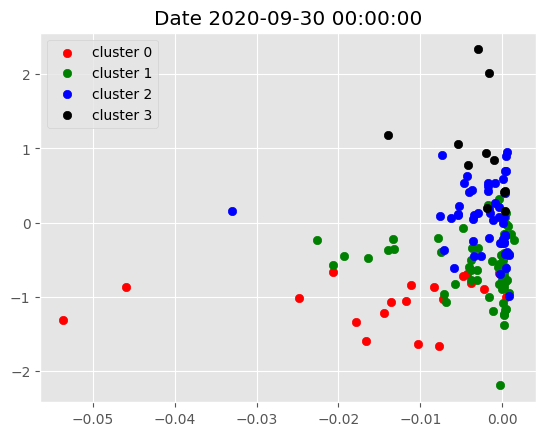

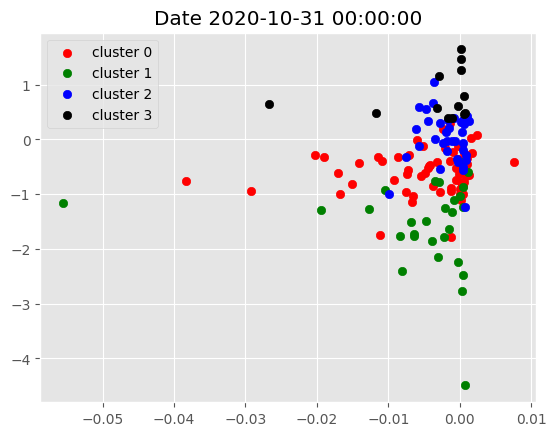

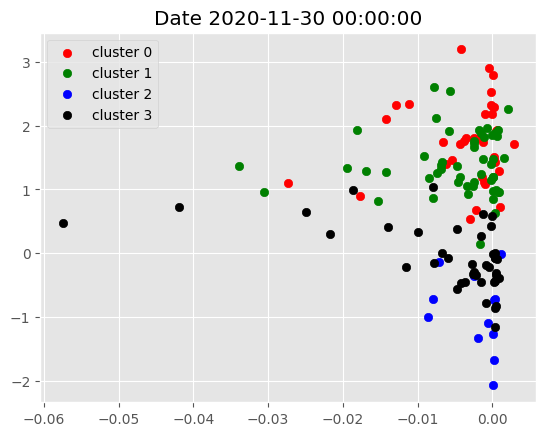

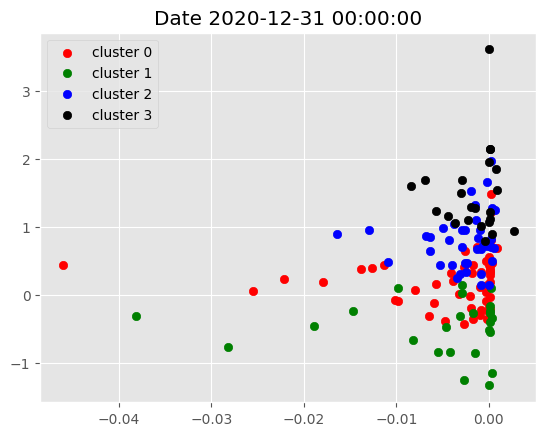

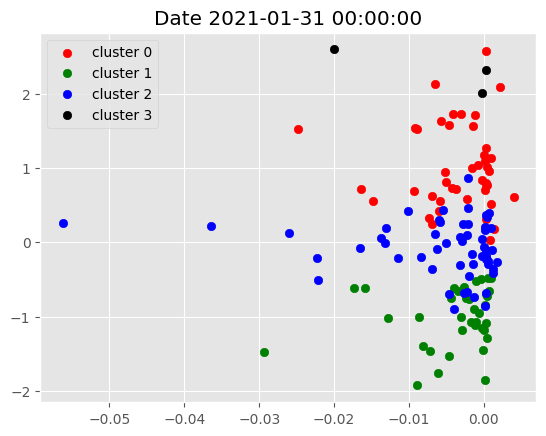

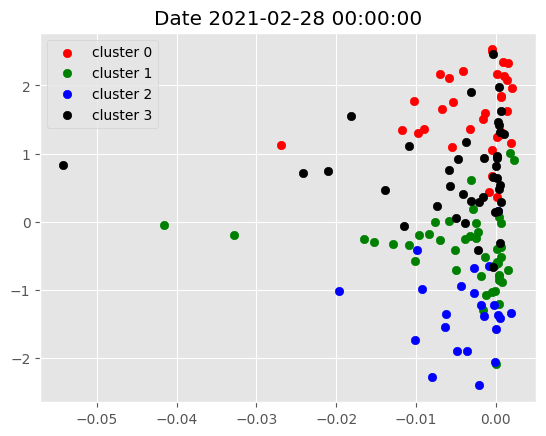

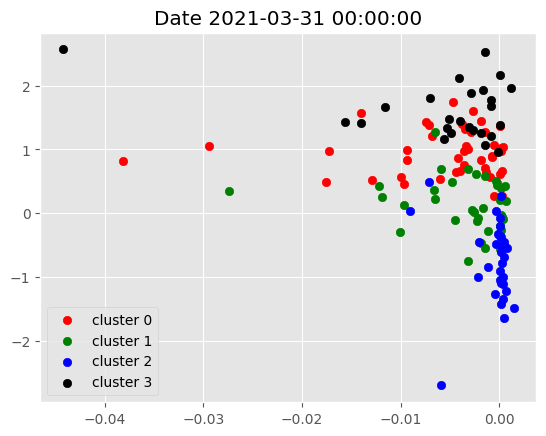

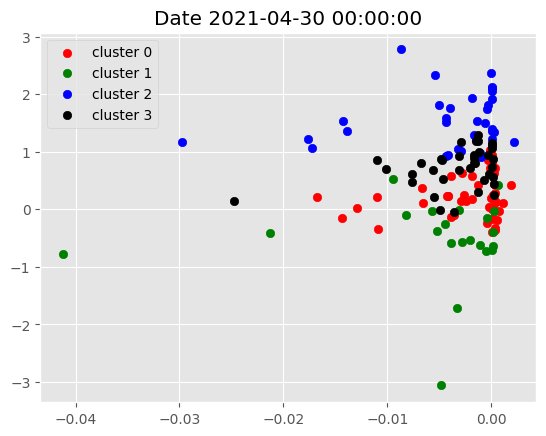

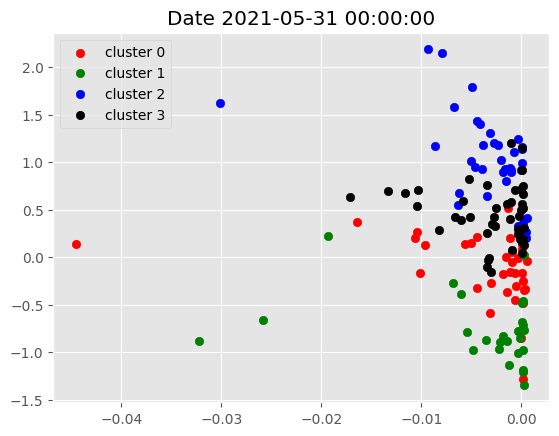

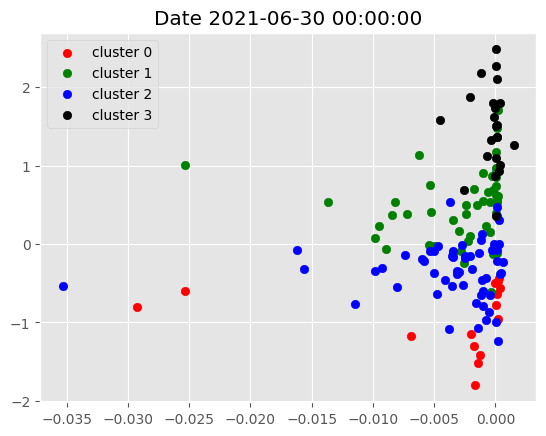

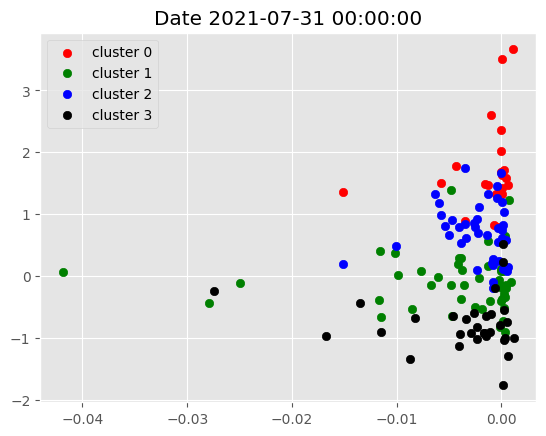

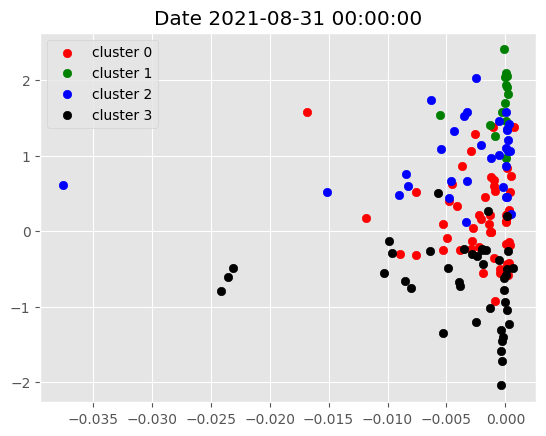

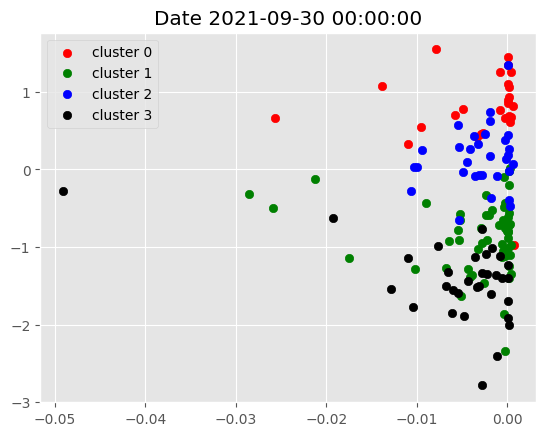

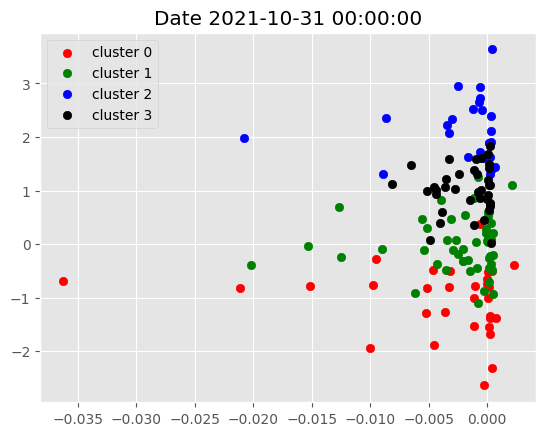

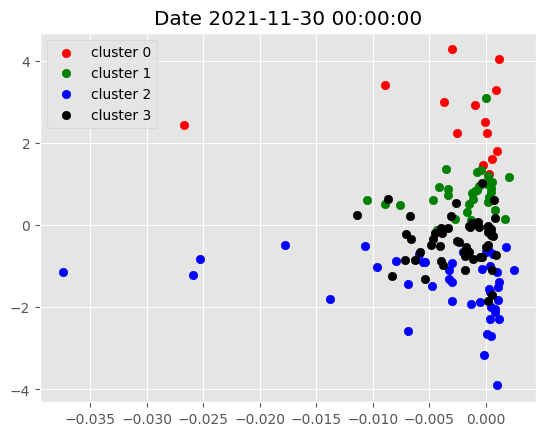

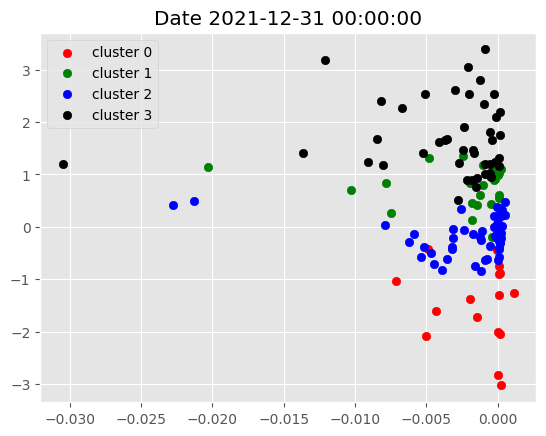

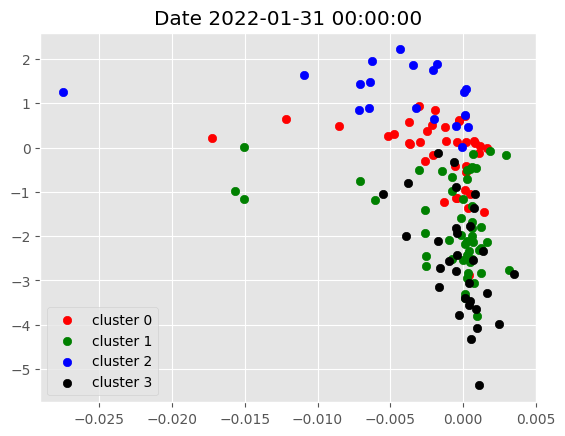

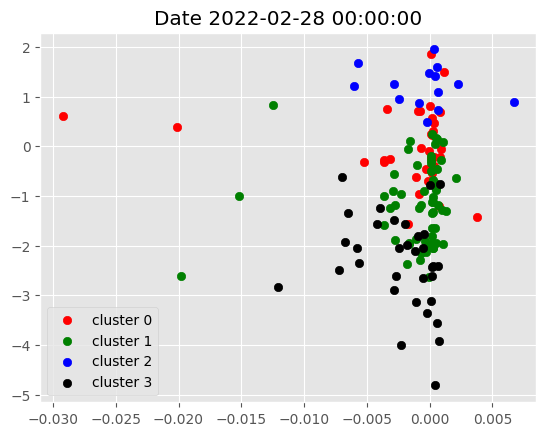

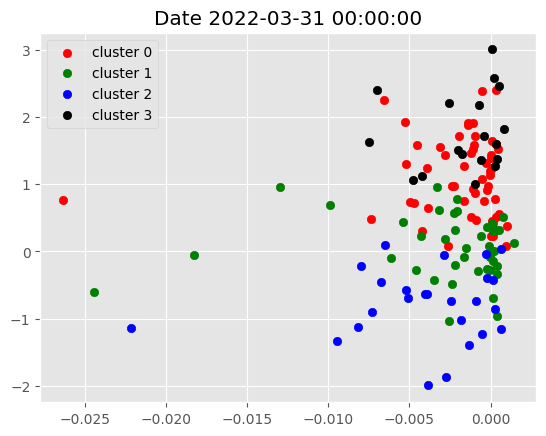

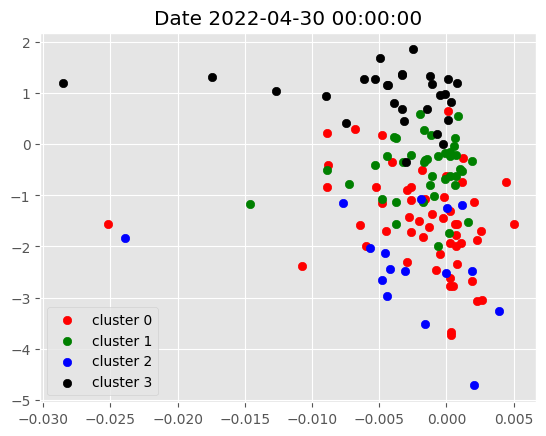

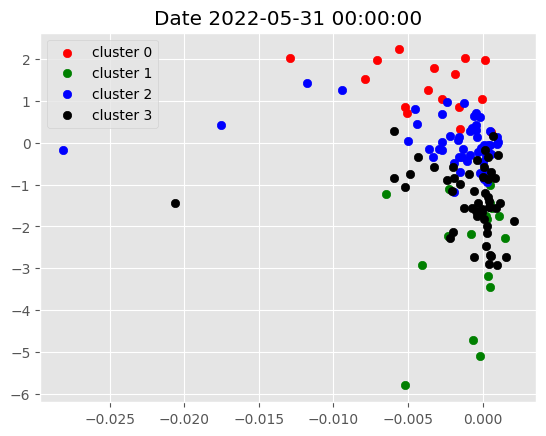

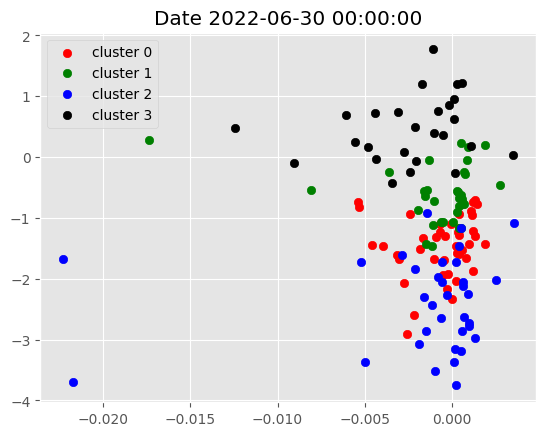

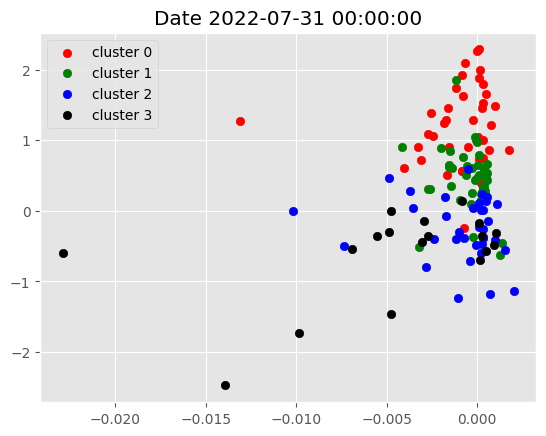

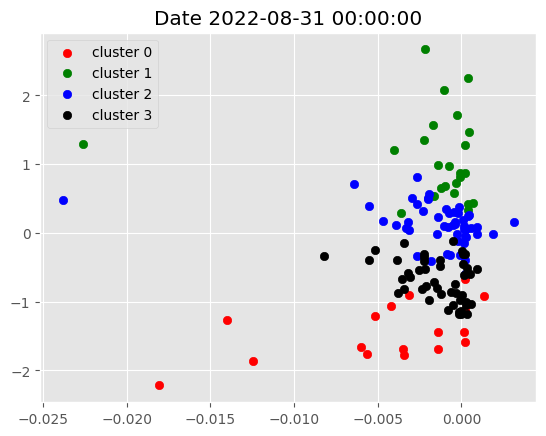

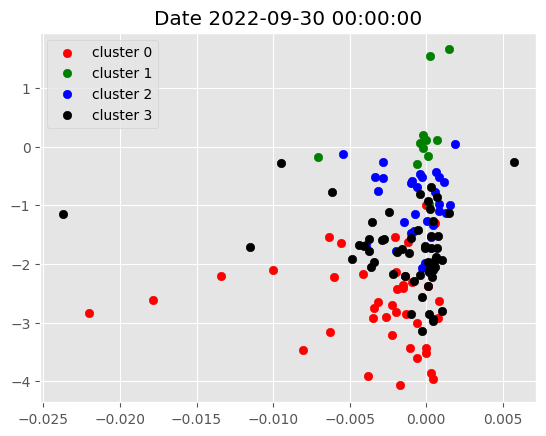

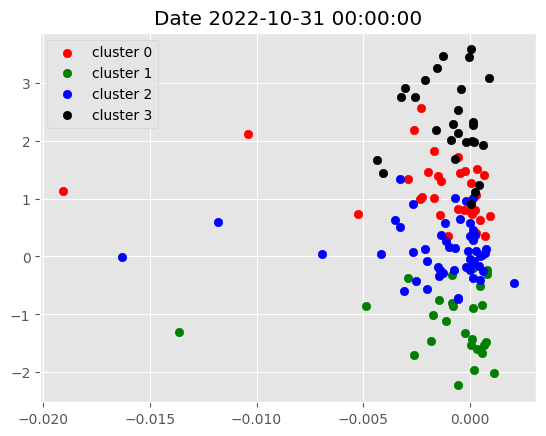

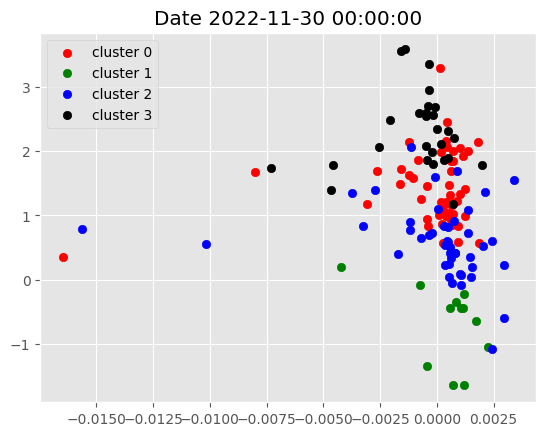

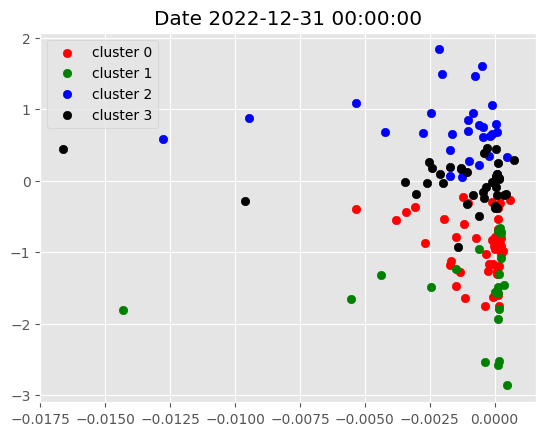

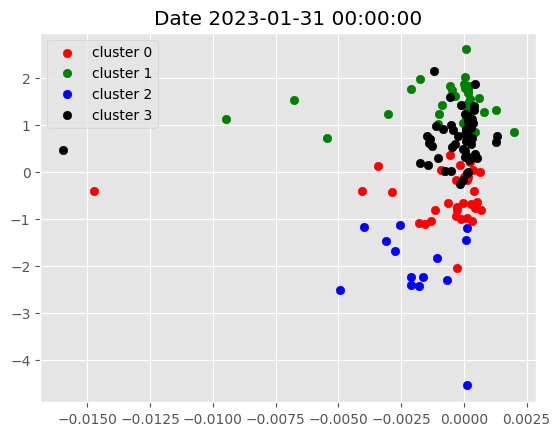

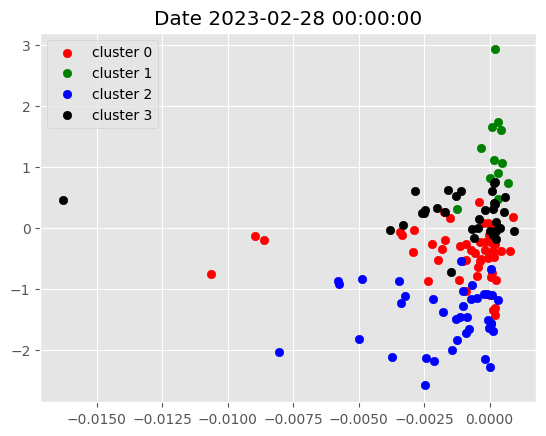

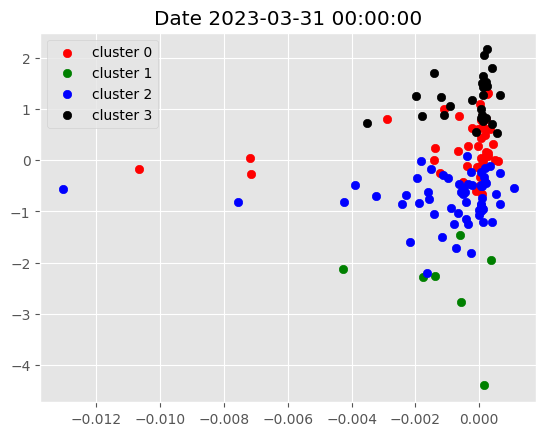

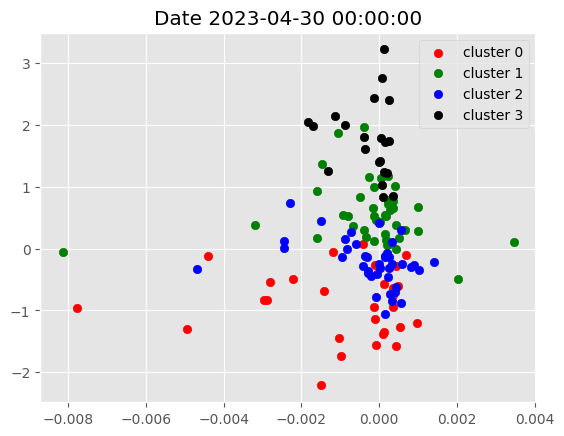

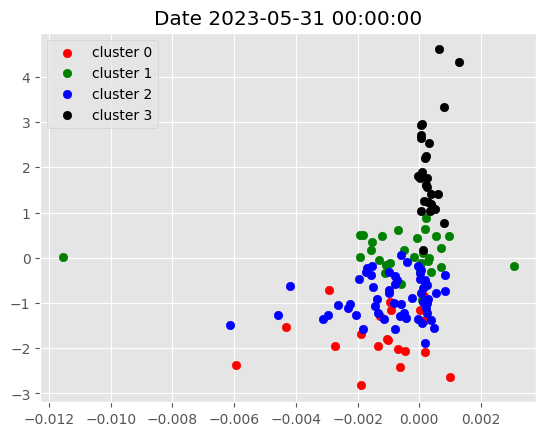

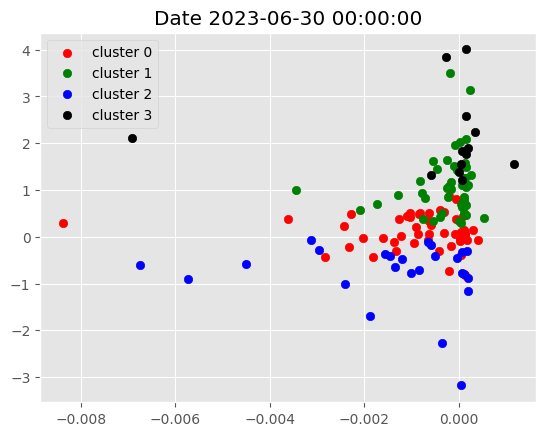

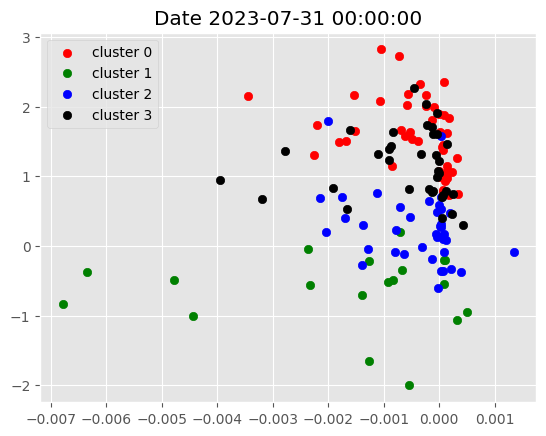

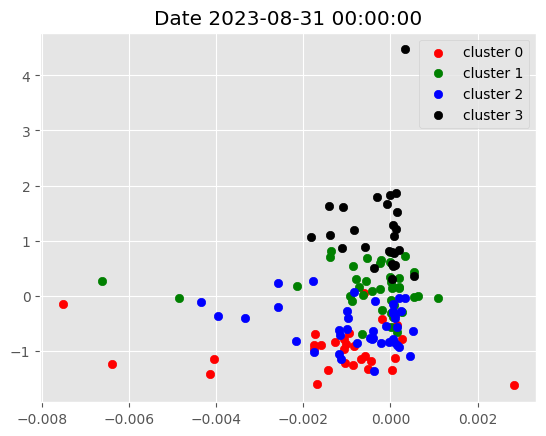

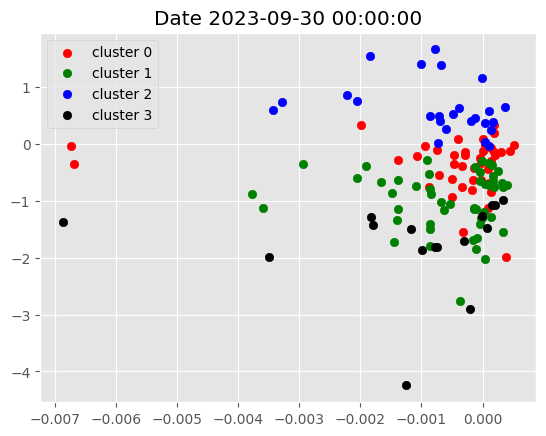

In [20]:
plt.style.use('ggplot')

for i in data3.index.get_level_values('date').unique().tolist():
    g = data3.xs(i, level = 0)
    plt.title(f'Date {i}')
    plot_clusters(g)

Pre-defined centroids

In [21]:
target_rsi_values = [30, 35, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:,6] = target_rsi_values
initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 35.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

Choose assets based on cluster and form a portfolio based on efficient frontier max sharpe ratio optimization

In [22]:
filtered_df = data3[data3['cluster'] == 3].copy()

filtered_df = filtered_df.reset_index(level = 1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates




{'2017-11-01': ['AMGN',
  'BIIB',
  'BMY',
  'BSX',
  'CCL',
  'CHTR',
  'CL',
  'CMCSA',
  'CSX',
  'CVX',
  'DAL',
  'DIS',
  'FCX',
  'HAL',
  'KR',
  'LLY',
  'LMT',
  'LUV',
  'MO',
  'PEP',
  'PFE',
  'QCOM',
  'SBUX',
  'SLB',
  'TGT',
  'TJX',
  'TSLA',
  'UAL',
  'ULTA',
  'UPS',
  'VZ'],
 '2017-12-01': ['AAPL',
  'AMGN',
  'BIIB',
  'BMY',
  'CCL',
  'CL',
  'CMCSA',
  'CMG',
  'COP',
  'CRM',
  'DD',
  'EOG',
  'GD',
  'GILD',
  'GM',
  'GOOG',
  'GOOGL',
  'JNJ',
  'KO',
  'LLY',
  'MA',
  'MCK',
  'MDT',
  'META',
  'NVDA',
  'ORCL',
  'PANW',
  'PG',
  'PYPL',
  'STZ',
  'TGT',
  'TMO',
  'TXN',
  'ULTA',
  'V',
  'WBA'],
 '2018-01-01': ['ABBV',
  'ADBE',
  'AMZN',
  'BIIB',
  'C',
  'CCL',
  'CHTR',
  'CSX',
  'CVS',
  'DD',
  'DHR',
  'DIS',
  'EBAY',
  'ELV',
  'F',
  'GD',
  'GOOG',
  'GOOGL',
  'GS',
  'HUM',
  'IBM',
  'JNJ',
  'KO',
  'MA',
  'MCD',
  'MCK',
  'MDLZ',
  'MDT',
  'META',
  'MMM',
  'MRK',
  'MS',
  'NEE',
  'NFLX',
  'NOC',
  'ORLY',
  'PANW',
  'PA

Portfolio Optimization function

In [23]:
# from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns

# def optimize_weights(prices, lower_bound = 0):
#     #Calculate returns
#     returns = expected_returns.mean_historical_return(prices = prices, frequency=252)
    
#     cov = risk_models.sample_cov(prices = prices,
#                                  frequency = 252)
#     #Calculate the covariance
#     ef = EfficientFrontier(expected_returns = returns, 
#                            cov_matrix = cov,
#                            weight_bounds = (lower_bound, .1),
#                            solver = 'SCS')
#     #Get optimize sharpe ratio weights
#     weights = ef.max_sharpe()
    
#     return ef.clean_weights()



from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [24]:
stocks = data3.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers = stocks,
                     start = data3.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                     end = data.index.get_level_values('date').unique()[-1],
                     auto_adjust = False
                     )

# stocks = data3.index.get_level_values('ticker').unique().tolist()

# new_df = yf.download(tickers=stocks,
#                      start=data3.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
#                      end=data3.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  156 of 156 completed


Price        Adj Close                                                 \
Ticker            AAPL        ABBV        ABT         ACN        ADBE   
Date                                                                    
2016-10-31   26.090458   38.501827  33.469265  101.760178  107.510002   
2016-11-01   25.619387   38.964287  33.307201  101.672646  106.870003   
2016-11-02   25.642365   39.198967  33.008678  103.834961  105.889999   
2016-11-03   25.367512   38.577759  32.735718  102.381714  107.169998   
2016-11-04   25.138853   38.681290  33.341328  102.626854  106.199997   
...                ...         ...        ...         ...         ...   
2023-09-25  174.569931  143.755936  93.684288  307.845001  511.600006   
2023-09-26  170.485291  143.068069  92.492447  301.649017  506.299988   
2023-09-27  168.968353  142.343018  91.819626  305.310272  502.600006   
2023-09-28  169.226166  141.524994  94.309044  292.092957  504.670013   
2023-09-29  169.741684  138.559708  93.088371  298.250031  509.899994   

Price                                                                  ...  \
Ticker             ADP        ADSK        AIG        AMAT         AMD  ...   
Date                                                                   ...   
2016-10-31   72.332794   72.279999  49.409809   26.357300    7.230000  ...   
2016-11-01   72.216499   70.099998  48.592987   26.194149    7.090000  ...   
2016-11-02   74.758865   68.680000  48.488888   25.913177    6.760000  ...   
2016-11-03   74.218819   67.610001  46.566956   25.623138    6.700000  ...   
2016-11-04   74.011116   69.440002  45.950325   25.577822    6.560000  ...   
...                ...         ...        ...         ...         ...  ...   
2023-09-25  231.056671  205.669998  59.895283  134.547714   97.379997  ...   
2023-09-26  228.380478  201.660004  59.056576  132.075241   95.959999  ...   
2023-09-27  233.569168  202.279999  58.815567  133.040588   98.070000  ...   
2023-09-28  234.223785  207.889999  59.075855  136.153351  102.760002  ...   
2023-09-29  231.595718  206.910004  58.420315  136.379898  102.820000  ...   

Price        Volume                                                            \
Ticker         VRTX        VZ       WBA     WDAY      WDC       WFC       WMT   
Date                                                                            
2016-10-31  1928200  12459400   4662100  1147300  4449514  20115900  19167000   
2016-11-01  2458200  13229400   5130800  1091400  5055315  20020200  26515800   
2016-11-02  2580400  16488200   9783100  1127800  5578033  19566600  22935900   
2016-11-03  2371000  12605100   4586500   633300  4223810  14982700  20411700   
2016-11-04  1902100  14410200   7023900   892600  3579509  27391600  21786300   
...             ...       ...       ...      ...      ...       ...       ...   
2023-09-25   698100  17616900   6891000   894200  3553446  10624000  10459500   
2023-09-26   633600  18841600   7570500  1217300  4724565  15219400  14435700   
2023-09-27   860600  22083500  10182900  2338100  3370739  11815500  15711000   
2023-09-28   578900  18772100   7291500  9196300  4342086  12454600  11617200   
2023-09-29   896800  19787600  25663400  4066600  3323376  13124500  18842400   

Price                                    
Ticker         WYNN       XOM       XYZ  
Date                                     
2016-10-31  1341600  16663800   2960600  
2016-11-01  3722300  13050600   8190900  
2016-11-02  2542400  11226100  19503200  
2016-11-03  9050400   8836500   7371500  
2016-11-04  3223800  13877100  13462800  
...             ...       ...       ...  
2023-09-25  1387800  11316000   8841300  
2023-09-26  1454000  11805400  10168200  
2023-09-27  2050000  23976200  11656100  
2023-09-28  1290400  16808100  16585100  
2023-09-29  1326800  18813600  11965300  

[1740 rows x 936 columns]

Daily returns for each stock which could land up in our portfolio.

In [25]:
# 1) Compute log‐diff returns once
returns_df = np.log(new_df['Adj Close']).diff()

# 2) Collect each month’s strategy‐return series in here
portfolio_returns = []

for start_date, cols in fixed_dates.items():
    start = pd.to_datetime(start_date)
    end   = start + pd.offsets.MonthEnd(0)
    opt_start = start - pd.DateOffset(months=12)
    opt_end   = start - pd.DateOffset(days=1)

    # slice price history and compute weights
    hist_prices = new_df['Adj Close'].loc[opt_start:opt_end, cols]
    try:
        wdict = optimize_weights(
            prices=hist_prices,
            lower_bound=1/(len(cols)*2)
        )
        weights = pd.Series(wdict)  # ticker → weight
    except Exception:
        print(f"Max Sharpe Ratio failed for {start_date}, using equal‐weights")
        weights = pd.Series(1/len(cols), index=cols)

    # slice returns for the month and do a dot‐product
    period_rets = returns_df.loc[start:end, cols]
    strat_ret   = period_rets.dot(weights)
    strat_ret.name = 'Strategy Return'

    portfolio_returns.append(strat_ret)

# concatenate into one DataFrame indexed by date
portfolio_df = pd.concat(portfolio_returns).to_frame()


print(weights)
print(portfolio_df)



Max Sharpe Ratio failed for 2019-06-01, using equal‐weights
Max Sharpe Ratio failed for 2019-09-01, using equal‐weights
Max Sharpe Ratio failed for 2021-02-01, using equal‐weights
Max Sharpe Ratio failed for 2022-08-01, using equal‐weights
Max Sharpe Ratio failed for 2022-10-01, using equal‐weights
ABT    0.03125
AMT    0.03125
BA     0.10000
DAL    0.10000
DG     0.03125
FI     0.10000
KO     0.05001
LMT    0.10000
MCD    0.10000
NKE    0.10000
PFE    0.03125
RTX    0.03125
TGT    0.03125
UAL    0.10000
UPS    0.03125
XYZ    0.03125
dtype: float64
            Strategy Return
Date                       
2017-11-01        -0.004432
2017-11-02        -0.004848
2017-11-03         0.005769
2017-11-06         0.002295
2017-11-07         0.004871
...                     ...
2023-09-25         0.003692
2023-09-26        -0.011821
2023-09-27         0.005059
2023-09-28         0.006242
2023-09-29        -0.007198

[1487 rows x 1 columns]


In [26]:
portfolio_df = pd.concat(portfolio_returns).to_frame()
portfolio_df

,Strategy Return
Date,
2017-11-01,-0.004432
2017-11-02,-0.004848
2017-11-03,0.005769
2017-11-06,0.002295
2017-11-07,0.004871
...,...
2023-09-25,0.003692
2023-09-26,-0.011821
2023-09-27,0.005059


In [27]:
spy = yf.download(tickers = 'SPY',
               start = '2015-01-01',
               end = dt.date.today(),
               auto_adjust = False
               )

spy_return = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy & Hold'}, axis = 1)


spy_return = (
    np.log(spy[['Adj Close']])
      .diff()
      .dropna()
      .rename({'Adj Close':'SPY Buy & Hold'}, axis=1)
)

# this will drop the ticker‐level so you end up with a single‐level Index:
if spy_return.columns.nlevels > 1:
    spy_return.columns = spy_return.columns.droplevel(-1)


portfolio_df = portfolio_df.merge(
    spy_return,
    how = 'left',
    left_index = True,
    right_index = True
)

print("portfolio_df column levels:", portfolio_df.columns.nlevels)
print("spy_return column levels:  ", spy_return.columns.nlevels)

portfolio_df

[*********************100%***********************]  1 of 1 completed

portfolio_df column levels: 1
spy_return column levels:   1


,Strategy Return,SPY Buy & Hold
Date,,
2017-11-01,-0.004432,0.001321
2017-11-02,-0.004848,0.000388
2017-11-03,0.005769,0.003333
2017-11-06,0.002295,0.001547
2017-11-07,0.004871,-0.000696
...,...,...
2023-09-25,0.003692,0.004196
2023-09-26,-0.011821,-0.014800
2023-09-27,0.005059,0.000399


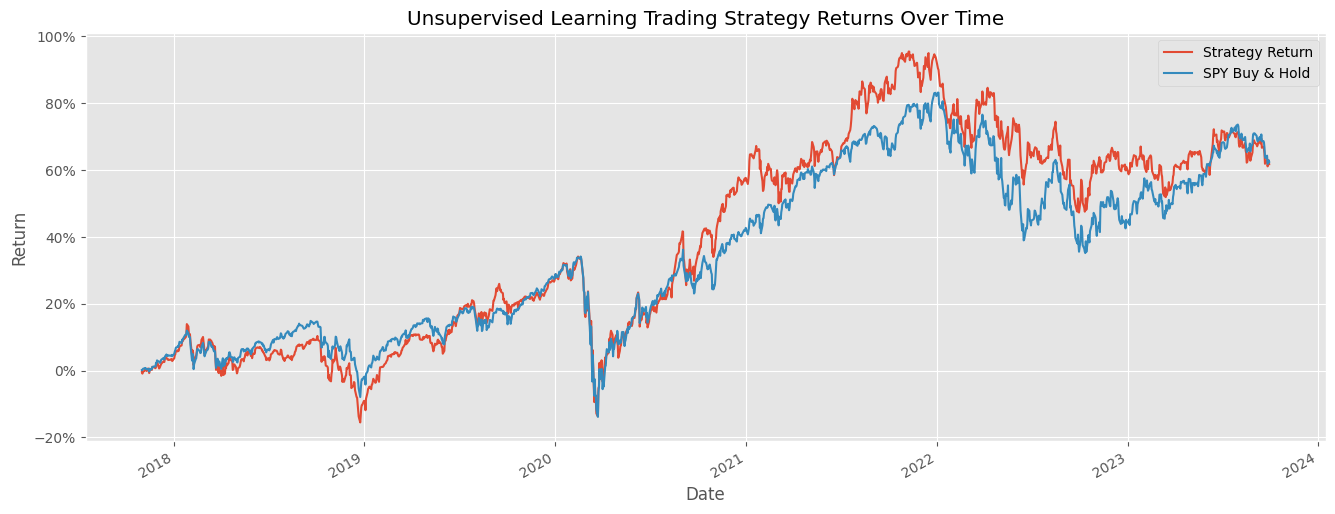

In [28]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

Twitter Sentiment Analysis

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = ''

sentiment_df = pd.read_csv('/Users/choongtetsan/Downloads/quant trading python/sentiment_data.csv')

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

Aggregate monthly and calculate average sentiment for the month

In [30]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

Top 5 stocks based on cross-sectional ranking

In [32]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

In [34]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

New stock price for shortlisted stocks

In [50]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers = stocks_list,
                        start = '2021-01-01',
                        end = '2023-03-01',
                        auto_adjust=False)
prices_df.head(10)

[*********************100%***********************]  85 of 85 completed

2 Failed downloads:
['MRO', 'ATVI']: YFTzMissingError('possibly delisted; no timezone found')


Price        Adj Close                                                \
Ticker               A        AAL         AAP        AAPL       ABBV   
Date                                                                   
2021-01-04  115.095329  15.130000  141.324203  126.239685  87.365036   
2021-01-05  116.036362  15.430000  141.171524  127.800468  88.268410   
2021-01-06  119.218361  15.520000  149.327301  123.498535  87.505936   
2021-01-07  122.390656  15.380000  150.602722  127.712738  88.442482   
2021-01-08  123.263763  15.130000  152.749420  128.815002  88.906616   
2021-01-11  124.321190  15.000000  153.611755  125.820221  90.357025   
2021-01-12  123.176445  15.380000  158.686615  125.644638  90.986938   
2021-01-13  123.186157  15.530000  154.276398  127.683418  93.199860   
2021-01-14  122.264526  16.440001  151.644653  125.751968  93.602341   
2021-01-15  122.439163  15.760000  148.429062  124.025307  92.671593   

Price                                                                ...  \
Ticker             ABT        AEP        AES         ALB        AMD  ...   
Date                                                                 ...   
2021-01-04  100.130600  68.997726  19.576612  145.072220  92.300003  ...   
2021-01-05  101.369492  68.904655  20.233662  154.862198  92.769997  ...   
2021-01-06  101.158424  69.454666  21.042328  166.429550  90.330002  ...   
2021-01-07  102.140366  67.601532  20.831736  174.888885  95.160004  ...   
2021-01-08  102.424850  67.000732  21.412973  174.983902  94.580002  ...   
2021-01-11  101.718239  66.662270  21.446663  168.511139  97.250000  ...   
2021-01-12   99.882812  65.866867  21.918390  173.463181  95.360001  ...   
2021-01-13  102.920410  66.129189  22.642826  171.010925  91.779999  ...   
2021-01-14  101.390892  66.704567  23.122978  173.339584  90.790001  ...   
2021-01-15  102.551857  68.092308  23.249331  171.219971  88.209999  ...   

Price        Volume                                                            \
Ticker          RCL     REGN       SLB      STZ         T      TMO       TSLA   
Date                                                                            
2021-01-04  5732800   911100   8743400  1202600  86700816  2220400  145914600   
2021-01-05  4029500   797700  16256600  1530200  83054520  2046700   96735600   
2021-01-06  3612500  1434700  19456300  1861700  73455520  2112300  134100000   
2021-01-07  3993700  1126600  14502400  2537100  71265359  2144400  154496700   
2021-01-08  3104200  1018800  11951900  1595400  72471656  2221700  225166500   
2021-01-11  2723400  1115300  16877000  1099700  40833484  1669600  177904800   
2021-01-12  2763100  1264100  20803200  1679100  57515222  2039000  138812100   
2021-01-13  2772100  1333800  11276800  1542000  51383116  1410200   99937500   
2021-01-14  5228200   848600  10285800  1109900  84548919  1426700   93798900   
2021-01-15  3125000   796900  13449000  1068900  53824704  1892600  116332800   

Price                                    
Ticker          TSN         V       XOM  
Date                                     
2021-01-04  2177400  10318300  27764700  
2021-01-05  2297100   6869700  44035100  
2021-01-06  1942200   7206200  36484800  
2021-01-07  2969400  10967900  29528100  
2021-01-08  2672400   6513000  28628200  
2021-01-11  2021800   7353100  38246200  
2021-01-12  3261500   9331600  36915100  
2021-01-13  2496400   6688500  29000300  
2021-01-14  1720100  12887500  35474800  
2021-01-15  1653600   8755000  42411300  

[10 rows x 510 columns]

In [51]:
prices_df.head()

Price        Adj Close                                                        \
Ticker               A    AAL         AAP        AAPL       ABBV         ABT   
Date                                                                           
2021-01-04  115.095329  15.13  141.324203  126.239685  87.365036  100.130600   
2021-01-05  116.036362  15.43  141.171524  127.800468  88.268410  101.369492   
2021-01-06  119.218361  15.52  149.327301  123.498535  87.505936  101.158424   
2021-01-07  122.390656  15.38  150.602722  127.712738  88.442482  102.140366   
2021-01-08  123.263763  15.13  152.749420  128.815002  88.906616  102.424850   

Price                                                    ...   Volume  \
Ticker            AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  68.997726  19.576612  145.072220  92.300003  ...  5732800   
2021-01-05  68.904655  20.233662  154.862198  92.769997  ...  4029500   
2021-01-06  69.454666  21.042328  166.429550  90.330002  ...  3612500   
2021-01-07  67.601532  20.831736  174.888885  95.160004  ...  3993700   
2021-01-08  67.000732  21.412973  174.983902  94.580002  ...  3104200   

Price                                                                          \
Ticker         REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  

[5 rows x 510 columns]

Portfolio Returns

In [73]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna(how ='all')
returns_df.head()

Ticker,A,AAL,AAP,AAPL,ABBV,ABT,AEP,AES,ALB,AMD,...,RCL,REGN,SLB,STZ,T,TMO,TSLA,TSN,V,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-05,0.008143,0.019634,-0.001081,0.012288,0.010287,0.012297,-0.001350,0.033012,0.065304,0.005079,...,0.025548,0.001221,0.052363,0.000692,-0.006133,0.012427,0.007291,-0.000788,-0.015037,0.047068
2021-01-06,0.027053,0.005816,0.056165,-0.034241,-0.008676,-0.002084,0.007951,0.039188,0.072036,-0.026654,...,-0.004836,-0.028024,0.053862,0.031005,0.019293,0.015557,0.027995,0.029658,-0.008850,0.025197
2021-01-07,0.026261,-0.009062,0.008505,0.033554,0.010646,0.009660,-0.027044,-0.010058,0.049579,0.052090,...,0.024355,0.023359,0.019072,0.022759,0.002678,0.030686,0.076448,-0.011541,0.005581,0.007815
2021-01-08,0.007108,-0.016388,0.014153,0.008594,0.005234,0.002781,-0.008927,0.027519,0.000543,-0.006114,...,-0.013746,0.035782,-0.001609,0.005838,-0.006920,0.023643,0.075481,-0.009017,0.007641,0.011060
2021-01-11,0.008542,-0.008629,0.005630,-0.023523,0.016182,-0.006923,-0.005064,0.001572,-0.037692,0.027839,...,-0.011717,0.008366,0.006021,-0.014571,-0.005182,0.002047,-0.081442,0.011491,-0.011953,0.029905


In [74]:
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date]
    
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


Use NASDAQ prices and calculate returns to compare to our strategy

In [109]:
qqq_data = yf.download(tickers='QQQ',
                    start = "2021-01-01",
                    end = '2023-03-01',
                    auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [110]:
qqq_df = qqq_data
qqq_df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,,
2021-01-04,300.898193,309.309998,315.290009,305.179993,315.109985,45305900
2021-01-05,303.378906,311.859985,312.140015,308.290009,308.290009,29323400
2021-01-06,299.176422,307.540009,311.880005,305.980011,307.000000,52809600
2021-01-07,306.414001,314.980011,315.839996,310.250000,310.279999,30394800
2021-01-08,310.353943,319.029999,319.390015,315.079987,317.339996,33955800


In [113]:
adj_close_ser = qqq_df['Adj Close']['QQQ']

#Compute log-diff and give it the right name
qqq_ret = np.log(adj_close_ser).diff().rename('nasdaq_return')

#drop the first NaN row so your merge doesn’t introduce NaNs
qqq_ret = qqq_ret.dropna()

portfolio_df = portfolio_df.drop(columns='nasdaq_return')
#Merge into your existing portfolio_df (which already has portfolio_return)
portfolio_df = portfolio_df.merge(
    qqq_ret,
    left_index=True,
    right_index=True,
    how='inner'
)

portfolio_df.head(10)

,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017160
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
2021-12-08,0.001167,0.004465
2021-12-09,-0.011651,-0.014824
2021-12-10,0.007106,0.010812
2021-12-13,-0.025418,-0.014552


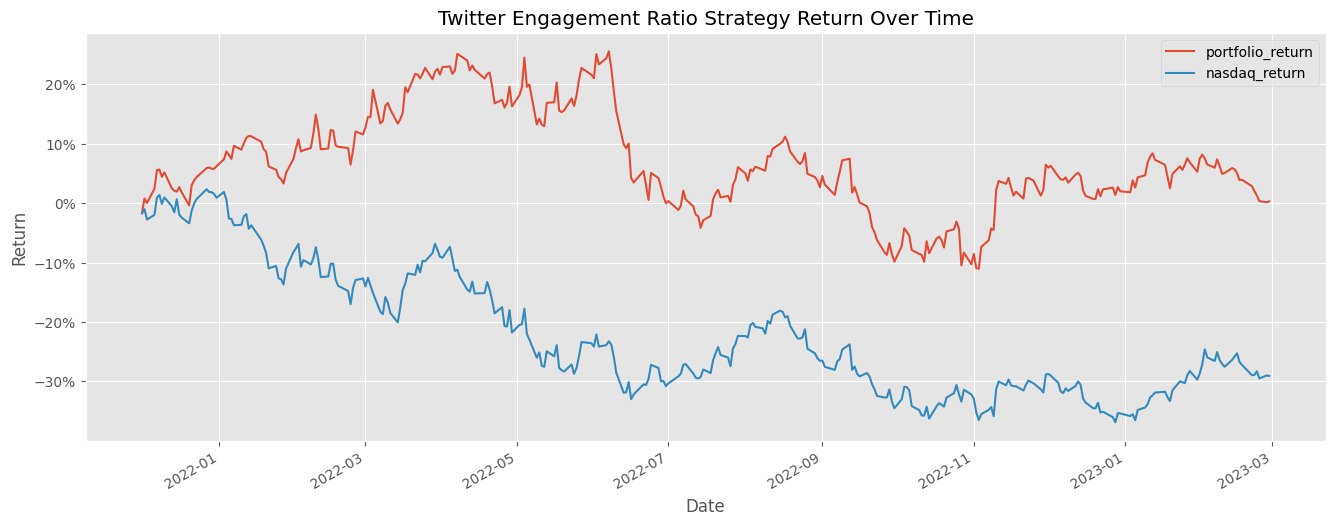

In [114]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

Fit GARCH model on daily data to predict 1-day ahead votality in a rolling window.
- calculate prediction premium and form daily signal from it
- generate position entry and hold until end of day
- calculate final strategy returns

In [116]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os



daily_df = pd.read_csv('simulated_daily_data.csv')

daily_df = daily_df.drop('Unnamed: 7', axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')


intraday_5min_df = pd.read_csv('simulated_5min_data.csv')

intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

intraday_5min_df

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


In [117]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020':]

def predict_volatility(x):
    
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

    print(x.index[-1])
    
    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df = daily_df.dropna()

daily_df

2020-06-28 00:00:00
2020-06-29 00:00:00
2020-06-30 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
2020-07-16 00:00:00
2020-07-17 00:00:00
2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-07-21 00:00:00
2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-24 00:00:00
2020-07-25 00:00:00
2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00
2020-07-30 00:00:00
2020-07-31 00:00:00
2020-08-01 00:00:00
2020-08-02 00:00:00
2020-08-03 00:00:00
2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-07 00:00:00
2020-08-08 00:00:00
2020-08-09 00:00:00
2020-08-10 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-15 00:00:00
2020-08-16 00:00:00
2020-08-17 00:00:00
2020-08-18 00:00:00
2020-08-19 00:00:00
2020-08-20 00:00:00
2020-08-21 00:00:00
2020-08-22 00:00:00
2020-08-23 00:00:00
2020-08-24 00:00:00
2020-08-25 00:00:00
2020-08-26 00:00:00
2020-08-27 00:00:00
2020-08-28 00:00:00
2020-08-29 00:00:00
2020-08-30 00:00:00
2020-08-31 00:00:00
2020-09-01 00:00:00
2020-09-02 00:00:00
2020-09-03 00:00:00
2020-09-04 00:00:00
2020-09-05 00:00:00
2020-09-06 00:00:00
2020-09-07 00:00:00
2020-09-08 00:00:00


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The 

2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00
2021-01-16 00:00:00
2021-01-17 00:00:00
2021-01-18 00:00:00
2021-01-19 00:00:00
2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00
2021-01-23 00:00:00
2021-01-24 00:00:00
2021-01-25 00:00:00
2021-01-26 00:00:00
2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-29 00:00:00
2021-01-30 00:00:00
2021-01-31 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00
2021-02-03 00:00:00
2021-02-04 00:00:00
2021-02-05 00:00:00
2021-02-06 00:00:00
2021-02-07 00:00:00
2021-02-08 00:00:00
2021-02-09 00:00:00
2021-02-10 00:00:00
2021-02-11 00:00:00
2021-02-12 00:00:00
2021-02-13 00:00:00
2021-02-14 00:00:00
2021-02-15 00:00:00
2021-02-16 00:00:00
2021-02-17 00:00:00
2021-02-18 00:00:00
2021-02-19 00:00:00
2021-02-20 00:00:00
2021-02-21 00:00:00
2021-02-22 00:00:00
2021-02-23 00:00:00
2021-02-24 00:00:00
2021-02-25 00:00:00
2021-02-26 00:00:00
2021-02-27 00:00:00
2021-02-28 00:00:00
2021-03-01 00:00:00


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-04 00:00:00
2021-03-05 00:00:00
2021-03-06 00:00:00
2021-03-07 00:00:00
2021-03-08 00:00:00
2021-03-09 00:00:00
2021-03-10 00:00:00
2021-03-11 00:00:00
2021-03-12 00:00:00
2021-03-13 00:00:00
2021-03-14 00:00:00
2021-03-15 00:00:00
2021-03-16 00:00:00
2021-03-17 00:00:00
2021-03-18 00:00:00
2021-03-19 00:00:00
2021-03-20 00:00:00
2021-03-21 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00
2021-03-24 00:00:00
2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-27 00:00:00
2021-03-28 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00
2021-04-02 00:00:00
2021-04-03 00:00:00
2021-04-04 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00
2021-04-09 00:00:00
2021-04-10 00:00:00
2021-04-11 00:00:00
2021-04-12 00:00:00
2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-06-04 00:00:00
2022-06-05 00:00:00
2022-06-06 00:00:00
2022-06-07 00:00:00
2022-06-08 00:00:00
2022-06-09 00:00:00
2022-06-10 00:00:00
2022-06-11 00:00:00
2022-06-12 00:00:00
2022-06-13 00:00:00
2022-06-14 00:00:00
2022-06-15 00:00:00
2022-06-16 00:00:00
2022-06-17 00:00:00
2022-06-18 00:00:00
2022-06-19 00:00:00
2022-06-20 00:00:00
2022-06-21 00:00:00
2022-06-22 00:00:00
2022-06-23 00:00:00
2022-06-24 00:00:00
2022-06-25 00:00:00
2022-06-26 00:00:00
2022-06-27 00:00:00
2022-06-28 00:00:00
2022-06-29 00:00:00
2022-06-30 00:00:00
2022-07-01 00:00:00
2022-07-02 00:00:00
2022-07-03 00:00:00


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-07-04 00:00:00
2022-07-05 00:00:00
2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-09 00:00:00
2022-07-10 00:00:00
2022-07-11 00:00:00
2022-07-12 00:00:00
2022-07-13 00:00:00
2022-07-14 00:00:00
2022-07-15 00:00:00
2022-07-16 00:00:00
2022-07-17 00:00:00
2022-07-18 00:00:00
2022-07-19 00:00:00
2022-07-20 00:00:00
2022-07-21 00:00:00
2022-07-22 00:00:00
2022-07-23 00:00:00
2022-07-24 00:00:00
2022-07-25 00:00:00
2022-07-26 00:00:00
2022-07-27 00:00:00
2022-07-28 00:00:00
2022-07-29 00:00:00
2022-07-30 00:00:00
2022-07-31 00:00:00
2022-08-01 00:00:00
2022-08-02 00:00:00
2022-08-03 00:00:00
2022-08-04 00:00:00
2022-08-05 00:00:00
2022-08-06 00:00:00
2022-08-07 00:00:00
2022-08-08 00:00:00
2022-08-09 00:00:00
2022-08-10 00:00:00
2022-08-11 00:00:00
2022-08-12 00:00:00
2022-08-13 00:00:00
2022-08-14 00:00:00
2022-08-15 00:00:00
2022-08-16 00:00:00
2022-08-17 00:00:00
2022-08-18 00:00:00
2022-08-19 00:00:00
2022-08-20 00:00:00
2022-08-21 00:00:00
2022-08-22 00:00:00


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2023-05-24 00:00:00
2023-05-25 00:00:00
2023-05-26 00:00:00
2023-05-27 00:00:00
2023-05-28 00:00:00
2023-05-29 00:00:00
2023-05-30 00:00:00
2023-05-31 00:00:00
2023-06-01 00:00:00
2023-06-02 00:00:00
2023-06-03 00:00:00
2023-06-04 00:00:00
2023-06-05 00:00:00
2023-06-06 00:00:00
2023-06-07 00:00:00
2023-06-08 00:00:00
2023-06-09 00:00:00
2023-06-10 00:00:00
2023-06-11 00:00:00
2023-06-12 00:00:00
2023-06-13 00:00:00
2023-06-14 00:00:00
2023-06-15 00:00:00
2023-06-16 00:00:00
2023-06-17 00:00:00
2023-06-18 00:00:00
2023-06-19 00:00:00
2023-06-20 00:00:00
2023-06-21 00:00:00
2023-06-22 00:00:00
2023-06-23 00:00:00
2023-06-24 00:00:00
2023-06-25 00:00:00
2023-06-26 00:00:00
2023-06-27 00:00:00
2023-06-28 00:00:00
2023-06-29 00:00:00
2023-06-30 00:00:00
2023-07-01 00:00:00
2023-07-02 00:00:00
2023-07-03 00:00:00
2023-07-04 00:00:00
2023-07-05 00:00:00
2023-07-06 00:00:00
2023-07-07 00:00:00
2023-07-08 00:00:00
2023-07-09 00:00:00
2023-07-10 00:00:00
2023-07-11 00:00:00
2023-07-12 00:00:00


,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions
Date,,,,,,,,,
2020-06-28,2262.115234,2299.386719,2243.881348,2285.895508,2285.895508,1.456087e+10,0.010797,0.002473,0.000728
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286


<Axes: xlabel='Date'>

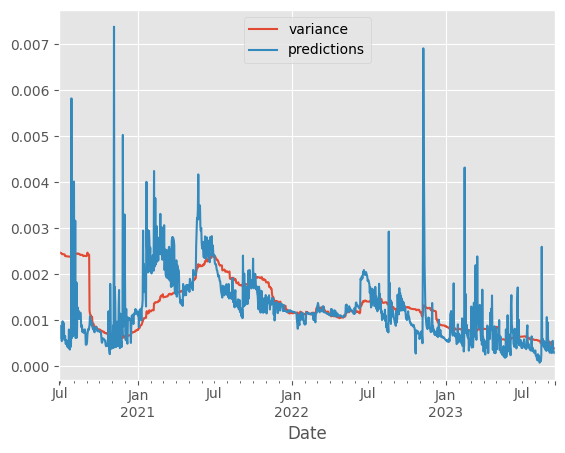

In [129]:
daily_df[['variance', 'predictions']].plot()

Calculate prediction premium and form a daily signal from it

In [130]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

#Calculate premium standard deviation
daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2020-06-28,2262.115234,2299.386719,2243.881348,2285.895508,2285.895508,1.456087e+10,0.010797,0.002473,0.000728,-0.705554,NaN,NaN
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651,-0.736678,NaN,NaN
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877,-0.644678,NaN,NaN
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618,-0.748360,NaN,NaN
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703,-0.713799,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334,-0.151792,0.531991,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292,-0.240812,0.529053,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286,-0.256793,0.527898,NaN


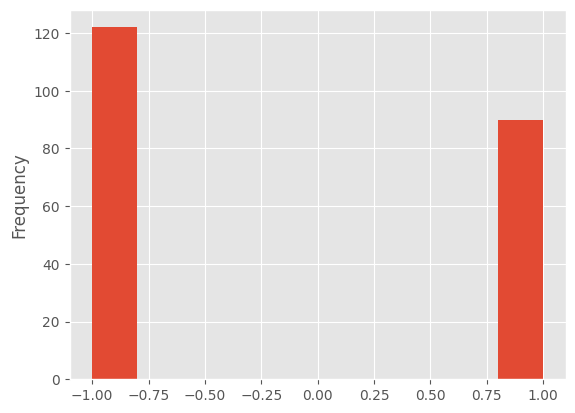

In [131]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

Merge with intraday data and calculate intraday indicators to form the intraday signal.

In [132]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday,return
datetime,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN,0.000018
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN,0.001269
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN,0.005589
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN,-0.000146
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN,0.000128
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN,0.000070
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN,-0.000158


Position for entry and hold

In [133]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

daily_return_df.head()

datetime
2021-09-29    0.0
2021-09-30    0.0
2021-10-01    0.0
2021-10-02    0.0
2021-10-03    0.0
Freq: D, Name: strategy_return, dtype: float64

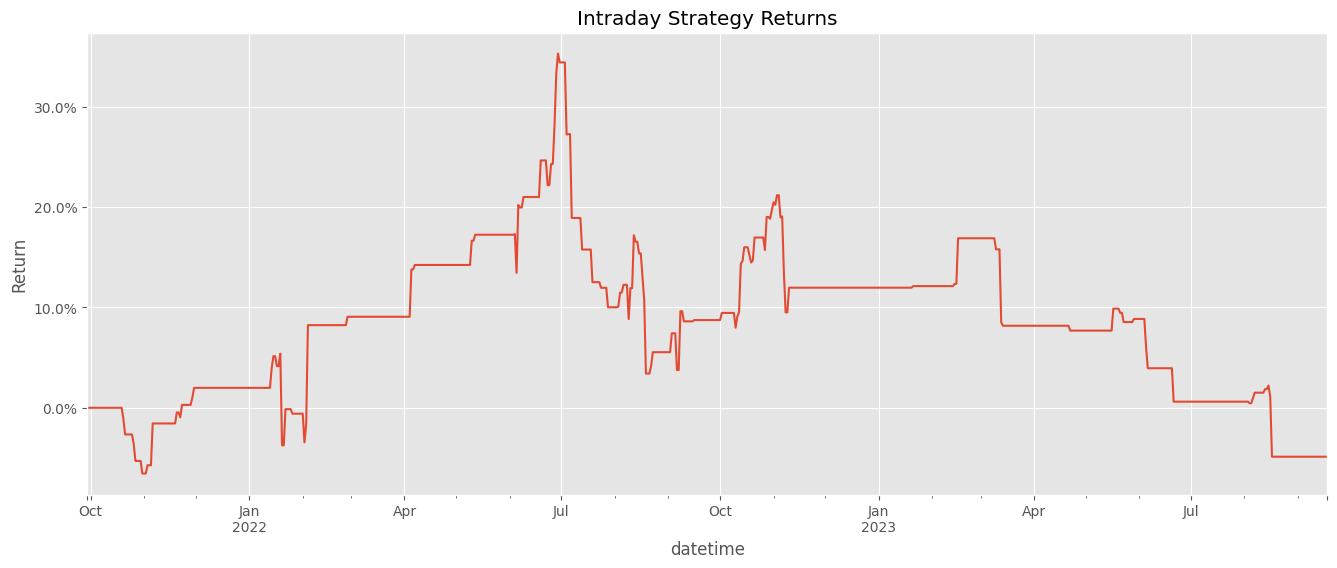

In [134]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()